In [1]:
import pandas as pd

In [2]:
df_b = pd.read_csv('barley_yield_from_1982(in).csv', sep=';')
df_b.drop(columns='Unnamed: 0', inplace=True)
df_b['yield'] = df_b['yield'].fillna(df_b['production'] / df_b['area'])

In [3]:
df_climatic = pd.read_parquet('climate_data_from_1982.parquet')

df_climatic_wide = df_climatic[df_climatic['scenario'] == 'historical'].pivot_table(
    index=['nom_dep', 'year', 'time'],
    columns='metric',
    values='value'
).reset_index()

In [4]:
df_climatic_wide.columns.name = None
df_climatic_wide = df_climatic_wide.rename(columns={
    'nom_dep': 'department',
    'near_surface_air_temperature': 'temp_avg',
    'daily_maximum_near_surface_air_temperature': 'temp_max',
    'precipitation': 'precip'
})
df_climatic_wide['temp_max'] -= 273.15
df_climatic_wide['temp_avg'] -= 273.15
df_climatic_wide['time'] = pd.to_datetime(df_climatic_wide['time'])

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STEP 0: 数据清洗与单位转换（在 copy 上操作，可安全重复执行）
# ============================================================
df_cw = df_climatic_wide.copy()
df_cw.columns.name = None
df_cw = df_cw.rename(columns={
    'nom_dep': 'department',
    'near_surface_air_temperature': 'temp_avg',
    'daily_maximum_near_surface_air_temperature': 'temp_max',
    'precipitation': 'precip'
})

# 温度：开尔文 → 摄氏度（安全检查，中位数>100 说明还没转）
if df_cw['temp_avg'].median() > 100:
    df_cw['temp_avg'] = df_cw['temp_avg'] - 273.15
    df_cw['temp_max'] = df_cw['temp_max'] - 273.15

# 降水：米 → 毫米（安全检查，最大值<1 说明还没转）
if df_cw['precip'].max() < 1:
    df_cw['precip'] = df_cw['precip'] * 1000

# 负降水置零
df_cw['precip'] = df_cw['precip'].clip(lower=0)

# 时间
df_cw['time'] = pd.to_datetime(df_cw['time'])
df_cw['year'] = df_cw['time'].dt.year
df_cw['month'] = df_cw['time'].dt.month

# 验证
print("=== 单位检查 ===")
print(f"temp_avg:  {df_cw['temp_avg'].min():.1f} ~ {df_cw['temp_avg'].max():.1f} °C")
print(f"temp_max:  {df_cw['temp_max'].min():.1f} ~ {df_cw['temp_max'].max():.1f} °C")
print(f"precip:    {df_cw['precip'].min():.3f} ~ {df_cw['precip'].max():.3f} mm")

=== 单位检查 ===
temp_avg:  -26.4 ~ 31.4 °C
temp_max:  -19.9 ~ 39.7 °C
precip:    0.000 ~ 5.103 mm


In [6]:
# ============================================================
# STEP 1: 逐日标记极端事件
# ============================================================

# 高温胁迫（大麦用 30°C 作阈值）
df_cw['is_heat_stress'] = (df_cw['temp_max'] > 30).astype(int)

# 霜冻日
df_cw['is_frost'] = (df_cw['temp_avg'] < 0).astype(int)

# GDD（生长积温），大麦基温 5°C
df_cw['gdd_day'] = (df_cw['temp_avg'] - 5).clip(lower=0)

# 降水阈值（基于百分位，适配空间平均数据）
precip_95 = df_cw.loc[df_cw['precip'] > 0.1, 'precip'].quantile(0.95)
print(f"有雨日 95th 百分位: {precip_95:.3f} mm")

df_cw['is_dry_day']    = (df_cw['precip'] < 0.1).astype(int)
df_cw['is_heavy_rain'] = (df_cw['precip'] > precip_95).astype(int)

# 温度日较差
df_cw['temp_range'] = df_cw['temp_max'] - df_cw['temp_avg']

有雨日 95th 百分位: 0.784 mm


In [7]:
# ============================================================
# STEP 2: 按部门-年聚合极端天气特征
# ============================================================

def max_consecutive(s):
    """最长连续 True 天数"""
    if not s.any():
        return 0
    groups = s.ne(s.shift()).cumsum()
    return s.groupby(groups).sum().max()

df_extreme = df_cw.groupby(['department', 'year']).apply(
    lambda g: pd.Series({
        # 基础气候
        'avg_temp':       g['temp_avg'].mean(),
        'total_precip':   g['precip'].sum(),
        'total_gdd':      g['gdd_day'].sum(),

        # 高温极端
        'heat_stress_days':       g['is_heat_stress'].sum(),
        'max_temp_year':          g['temp_max'].max(),
        'heat_wave_max_duration': max_consecutive(g['is_heat_stress'].astype(bool)),

        # 低温极端
        'frost_days':  g['is_frost'].sum(),
        'late_frost':  g.loc[g['month'].between(3, 5), 'is_frost'].sum(),
        'min_temp_year': g['temp_avg'].min(),

        # 降水极端
        'dry_days':           g['is_dry_day'].sum(),
        'max_consecutive_dry': max_consecutive(g['is_dry_day'].astype(bool)),
        'heavy_rain_days':    g['is_heavy_rain'].sum(),
        'max_daily_precip':   g['precip'].max(),
        'precip_cv':          g['precip'].std() / g['precip'].mean() if g['precip'].mean() > 0 else 0,

        # 温度波动
        'temp_std':       g['temp_avg'].std(),
        'avg_temp_range': g['temp_range'].mean(),
    })
).reset_index()

# 快速检查
print(df_extreme.describe().round(2))

          year  avg_temp  total_precip  total_gdd  heat_stress_days  \
count  2937.00   2937.00       2937.00    2937.00           2937.00   
mean   1998.00      9.90         35.19    2185.89             10.46   
std       9.52      2.20         15.48     510.43             11.20   
min    1982.00     -0.48          5.89     384.86              0.00   
25%    1990.00      8.99         23.95    1940.95              1.00   
50%    1998.00     10.20         33.62    2224.13              7.00   
75%    2006.00     11.24         44.04    2500.16             16.00   
max    2014.00     15.02        102.69    3709.90             65.00   

       max_temp_year  heat_wave_max_duration  frost_days  late_frost  \
count        2937.00                 2937.00     2937.00     2937.00   
mean           32.11                    4.09       30.42        3.59   
std             3.56                    3.84       29.24        7.48   
min            16.85                    0.00        0.00        0.00   


C:\Users\12066\AppData\Local\Temp\ipykernel_19744\1029977542.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extreme = df_cw.groupby(['department', 'year']).apply(


合并后: 2935 行, 89 个部门, 33 年
平均每年产量增长: 0.053 t/ha/yr
去趋势前 yield std:    1.362
去趋势后 residual std: 0.576


C:\Users\12066\AppData\Local\Temp\ipykernel_19744\915527031.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('department', group_keys=False).apply(detrend_yield)


气候异常变量: 16


C:\Users\12066\AppData\Local\Temp\ipykernel_19744\915527031.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('department', group_keys=False).apply(detrend_climate)


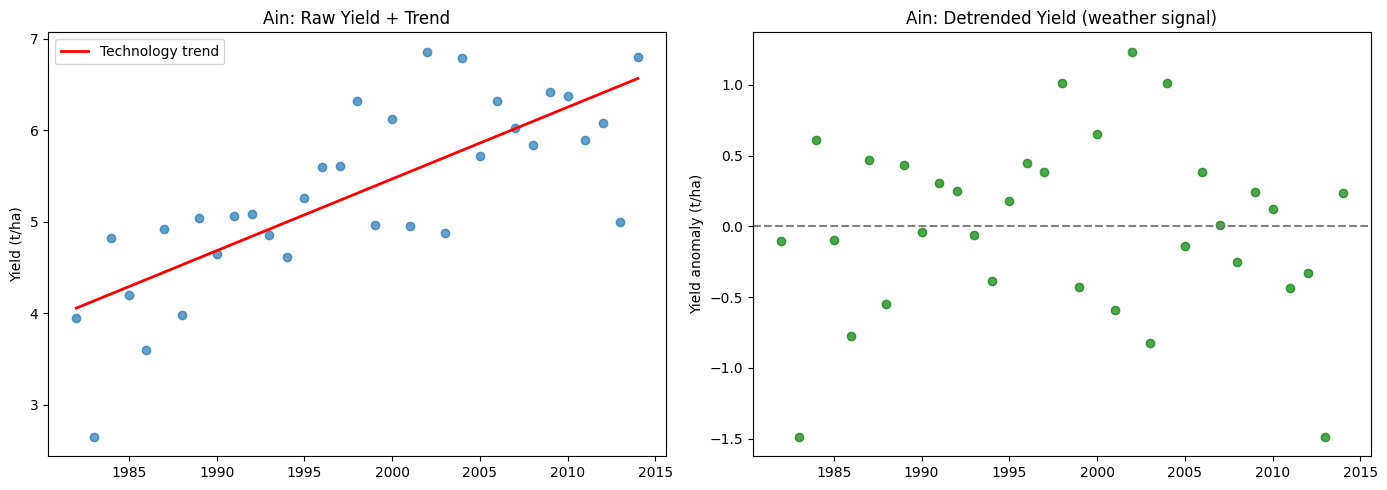

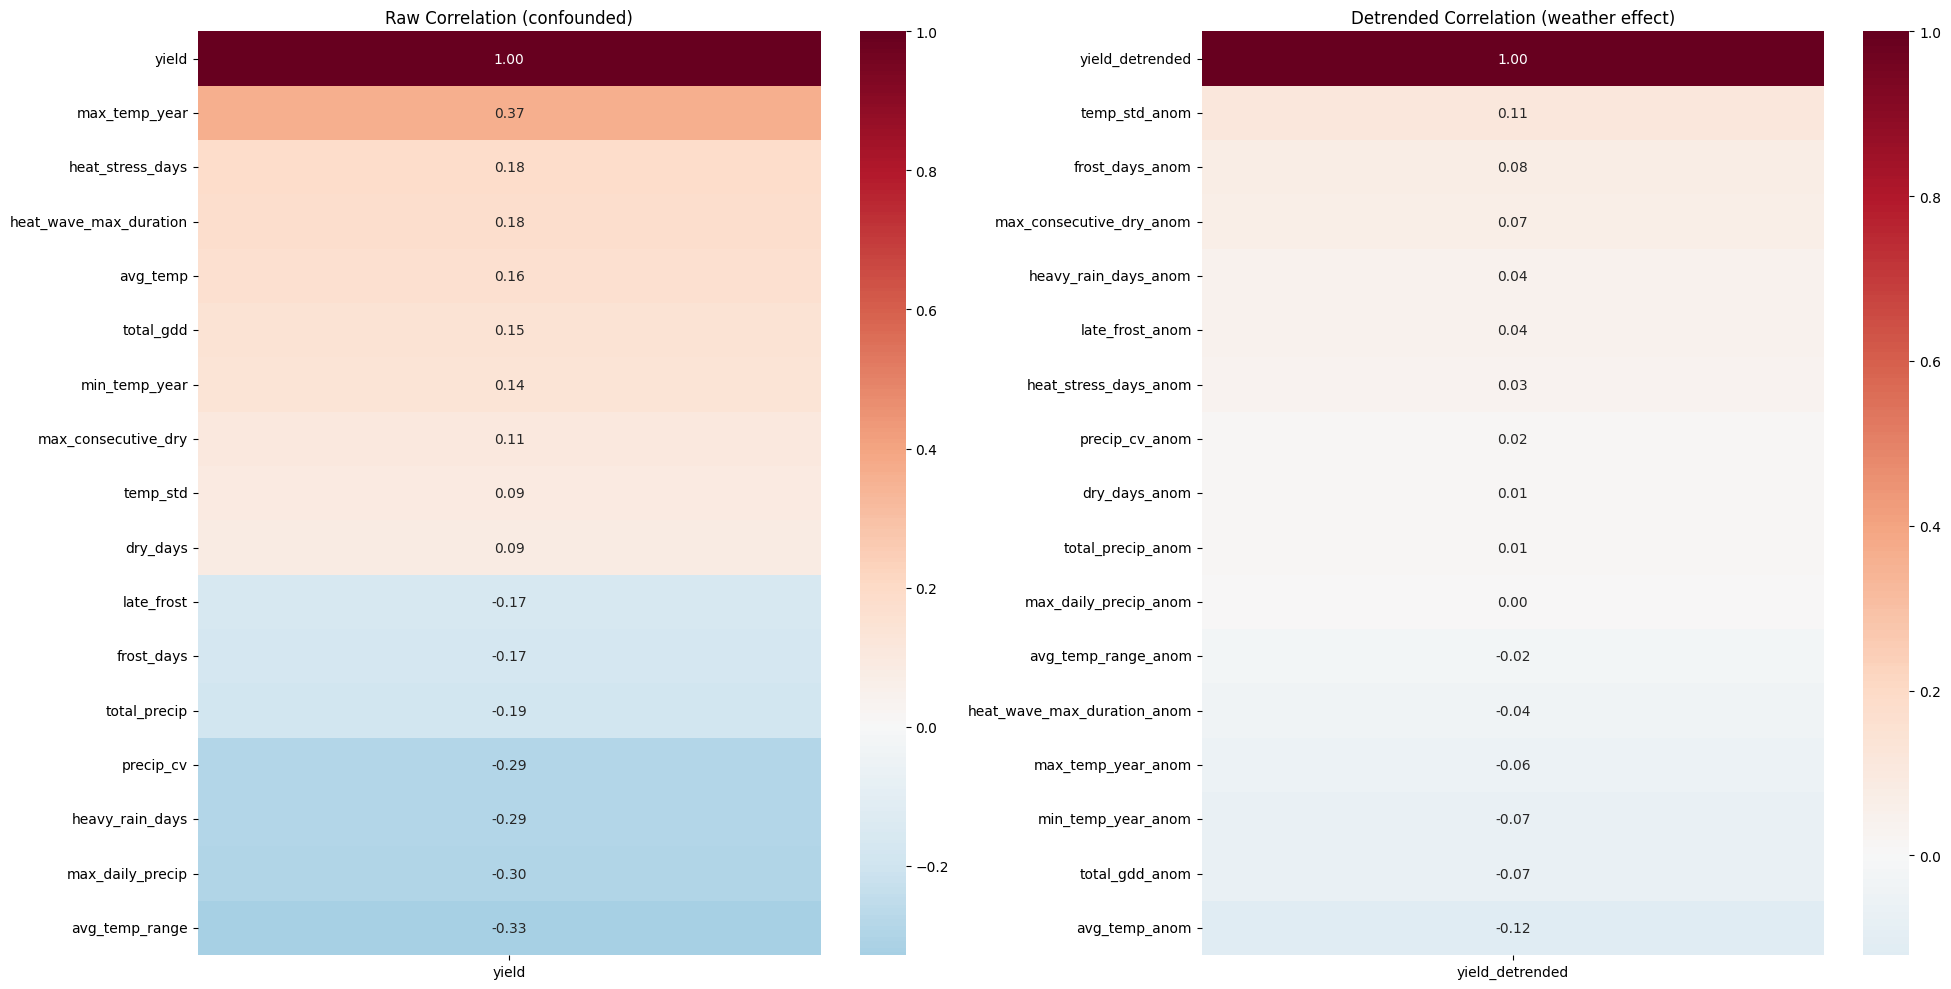

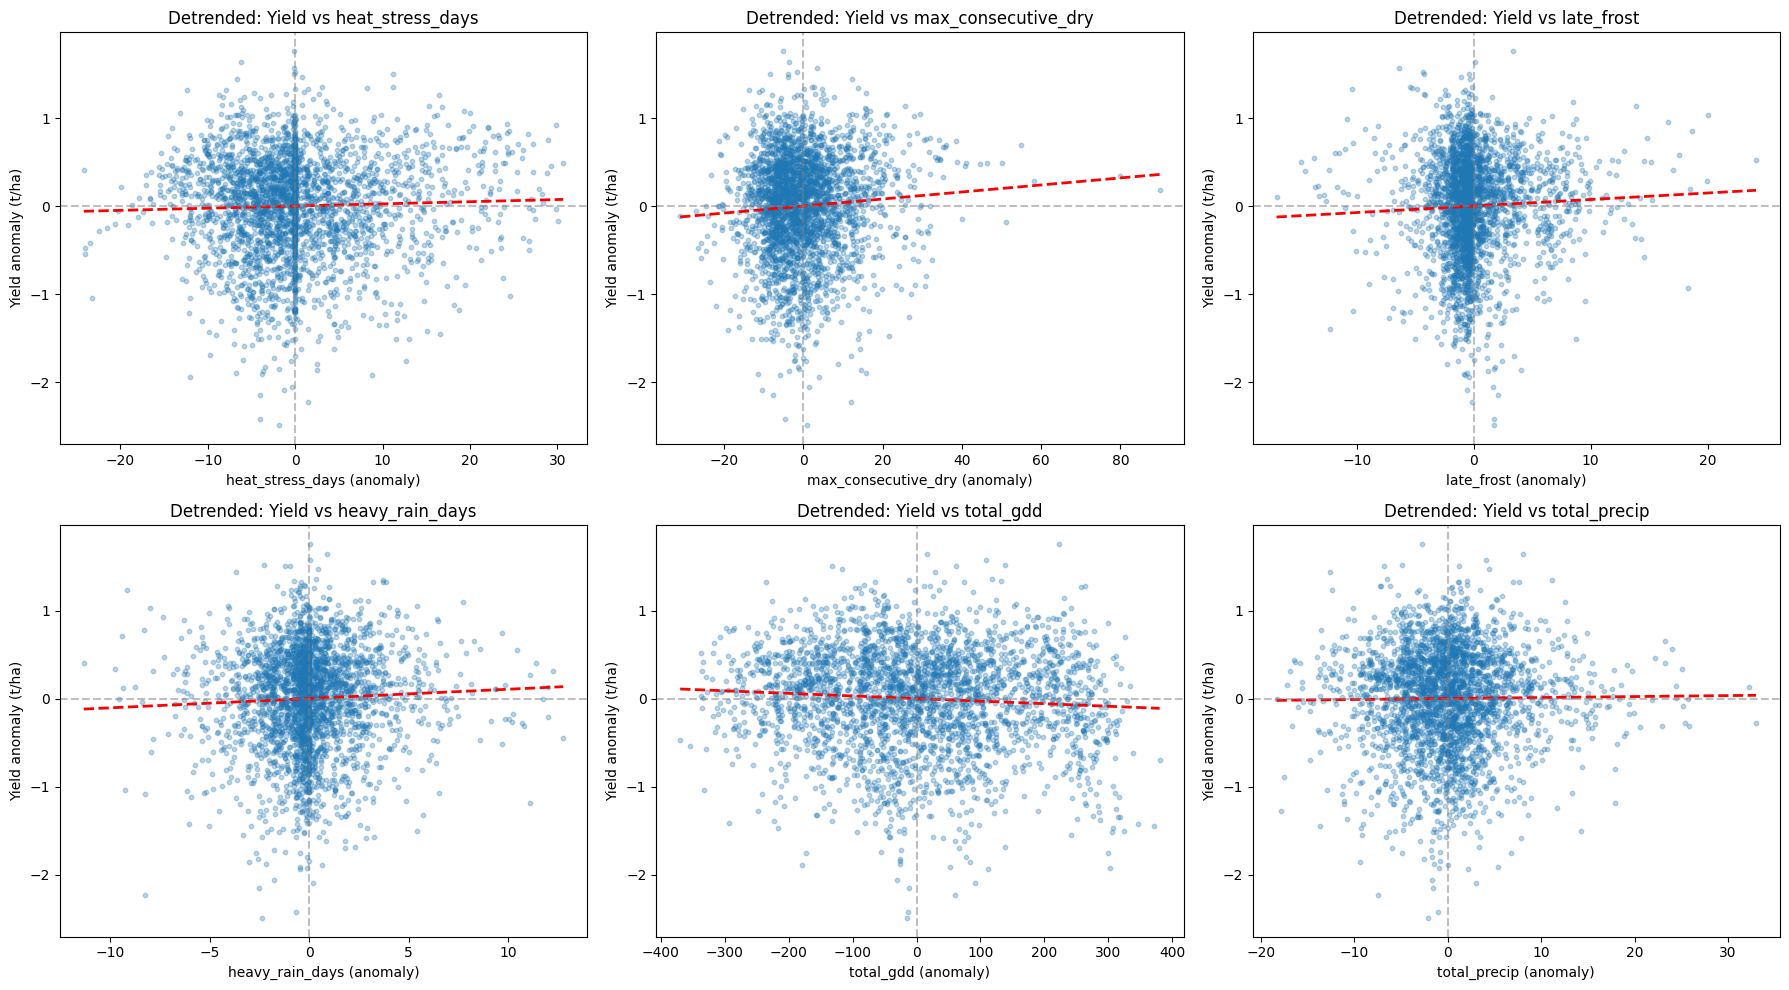


事件                 频次       占比           产量异常      歉收率      正常歉收率
极端高温              289    9.8%        +0.130 t/ha   10.4%     16.5%
持续干旱              280    9.5%        +0.024 t/ha   17.9%     15.7%
春季晚霜              280    9.5%        +0.065 t/ha   11.8%     16.3%
强降水频发             277    9.4%        +0.040 t/ha   13.0%     16.2%
热浪(≥5天)          1127   38.4%        -0.029 t/ha   18.5%     14.3%

RF 5-fold CV R² (detrended yield): 0.402 ± 0.022


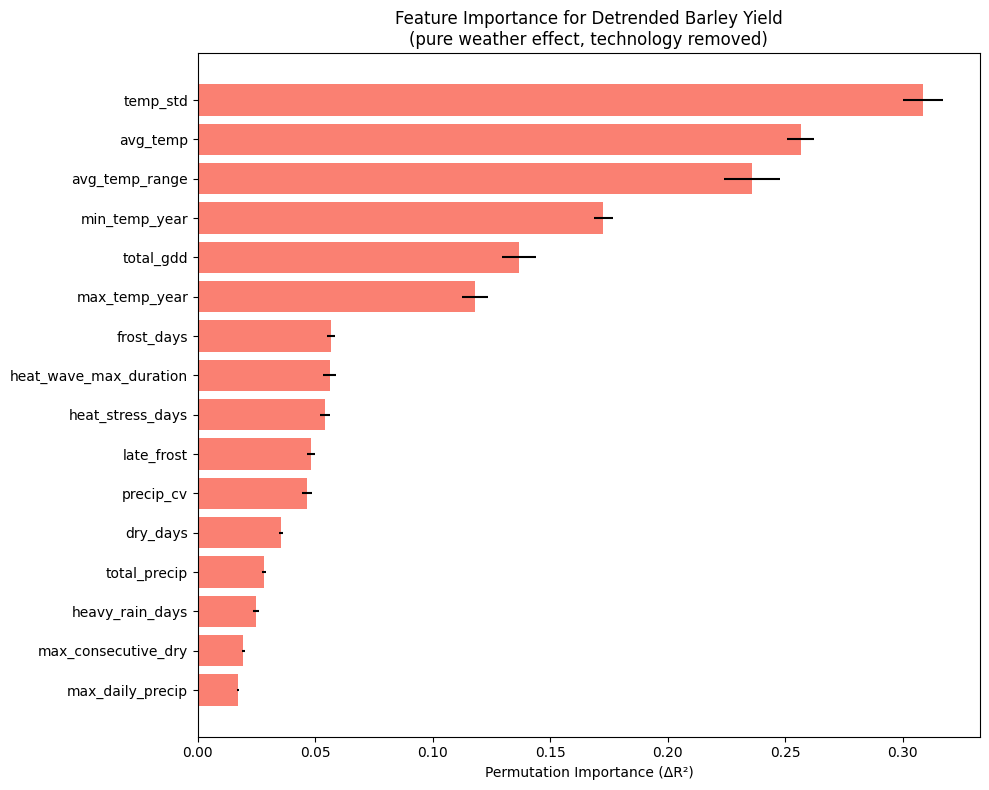


历史平均产量: 5.16 t/ha

场景                             产量偏差       相对影响
基准（正常年份）                    -0.010 t/ha      -0.2%
中度干旱                        +0.039 t/ha      +0.8%
严重干旱                        +0.043 t/ha      +0.8%
极端高温                        +0.104 t/ha      +2.0%
晚霜灾害                        -0.033 t/ha      -0.6%
复合灾害(高温+干旱)                 +0.098 t/ha      +1.9%


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

# ============================================================
# STEP 3: 合并产量
# ============================================================
df = df_extreme.merge(
    df_b[['department', 'year', 'yield']],
    on=['department', 'year'],
    how='inner'
)
df = df.dropna(subset=['yield'])
print(f"合并后: {df.shape[0]} 行, {df['department'].nunique()} 个部门, {df['year'].nunique()} 年")

# ============================================================
# STEP 3b: 逐部门线性去趋势（去除技术进步）
# ============================================================
climate_features = [
    'avg_temp', 'total_precip', 'total_gdd',
    'heat_stress_days', 'heat_wave_max_duration', 'max_temp_year',
    'frost_days', 'late_frost', 'min_temp_year',
    'dry_days', 'max_consecutive_dry', 'heavy_rain_days', 'max_daily_precip', 'precip_cv',
    'temp_std', 'avg_temp_range'
]

def detrend_yield(group):
    g = group.copy()
    x = g['year'].values.astype(float)
    y = g['yield'].values.astype(float)
    if len(x) < 3 or np.std(y) == 0:
        g['yield_trend'] = np.mean(y)
        g['yield_detrended'] = y - np.mean(y)
        g['trend_slope'] = 0.0
    else:
        coeffs = np.polyfit(x, y, 1)
        trend = np.polyval(coeffs, x)
        g['yield_trend'] = trend
        g['yield_detrended'] = y - trend
        g['trend_slope'] = coeffs[0]
    return g

df = df.groupby('department', group_keys=False).apply(detrend_yield)

print(f"平均每年产量增长: {df.groupby('department')['trend_slope'].first().mean():.3f} t/ha/yr")
print(f"去趋势前 yield std:    {df['yield'].std():.3f}")
print(f"去趋势后 residual std: {df['yield_detrended'].std():.3f}")

# ============================================================
# STEP 3c: 气候变量也去趋势
# ============================================================
def detrend_climate(group):
    g = group.copy()
    x = g['year'].values.astype(float)
    for col in climate_features:
        y = g[col].values.astype(float)
        if len(x) >= 3 and np.std(y) > 0:
            coeffs = np.polyfit(x, y, 1)
            g[col + '_anom'] = y - np.polyval(coeffs, x)
        else:
            g[col + '_anom'] = y - np.mean(y)
    return g

df = df.groupby('department', group_keys=False).apply(detrend_climate)
anom_features = [f + '_anom' for f in climate_features]
print(f"气候异常变量: {len(anom_features)}")

# ============================================================
# 画一个部门的去趋势示例
# ============================================================
sample_dept = df['department'].value_counts().idxmax()
sub = df[df['department'] == sample_dept].sort_values('year')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(sub['year'], sub['yield'], alpha=0.7)
axes[0].plot(sub['year'], sub['yield_trend'], 'r-', lw=2, label='Technology trend')
axes[0].set_title(f'{sample_dept}: Raw Yield + Trend')
axes[0].set_ylabel('Yield (t/ha)')
axes[0].legend()
axes[1].scatter(sub['year'], sub['yield_detrended'], alpha=0.7, color='green')
axes[1].axhline(0, color='gray', ls='--')
axes[1].set_title(f'{sample_dept}: Detrended Yield (weather signal)')
axes[1].set_ylabel('Yield anomaly (t/ha)')
plt.tight_layout()
plt.show()

# ============================================================
# STEP 4: 相关性对比（原始 vs 去趋势）
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

corr_raw = df[climate_features + ['yield']].corr()
sns.heatmap(corr_raw[['yield']].sort_values('yield', ascending=False),
            annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[0])
axes[0].set_title('Raw Correlation (confounded)')

corr_det = df[anom_features + ['yield_detrended']].corr()
sns.heatmap(corr_det[['yield_detrended']].sort_values('yield_detrended', ascending=False),
            annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1])
axes[1].set_title('Detrended Correlation (weather effect)')

plt.tight_layout()
plt.show()

# ============================================================
# STEP 5: 去趋势后散点图
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
key_features_anom = ['heat_stress_days_anom', 'max_consecutive_dry_anom', 'late_frost_anom',
                     'heavy_rain_days_anom', 'total_gdd_anom', 'total_precip_anom']

for ax, feat in zip(axes.ravel(), key_features_anom):
    x = df[feat].values.astype(float)
    y = df['yield_detrended'].values.astype(float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.3, s=10)
    if len(x) > 2 and np.std(x) > 0:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, p(x_line), 'r--', lw=2)
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(feat.replace('_anom', ' (anomaly)'))
    ax.set_ylabel('Yield anomaly (t/ha)')
    ax.set_title(f'Detrended: Yield vs {feat.replace("_anom","")}')
plt.tight_layout()
plt.show()

# ============================================================
# STEP 6: 极端事件影响（去趋势产量）
# ============================================================
df['yield_detrend_z'] = df.groupby('department')['yield_detrended'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)
df['is_bad_year'] = (df['yield_detrend_z'] < -1).astype(int)

thresholds = {
    '极端高温':     df['heat_stress_days'] > df['heat_stress_days'].quantile(0.90),
    '持续干旱':     df['max_consecutive_dry'] > df['max_consecutive_dry'].quantile(0.90),
    '春季晚霜':     df['late_frost'] > df['late_frost'].quantile(0.90),
    '强降水频发':   df['heavy_rain_days'] > df['heavy_rain_days'].quantile(0.90),
    '热浪(≥5天)':  df['heat_wave_max_duration'] >= 5,
}

print(f"\n{'事件':<14} {'频次':>6} {'占比':>8} {'产量异常':>14} {'歉收率':>8} {'正常歉收率':>10}")
print("=" * 66)
for name, mask in thresholds.items():
    n = mask.sum()
    if n == 0:
        print(f"{name:<14} {'无事件':>6}")
        continue
    anom = df.loc[mask, 'yield_detrended'].mean()
    bad  = df.loc[mask, 'is_bad_year'].mean()
    norm = df.loc[~mask, 'is_bad_year'].mean()
    print(f"{name:<14} {n:>6} {n/len(df):>7.1%} {anom:>+13.3f} t/ha {bad:>7.1%} {norm:>9.1%}")

# ============================================================
# STEP 7: 随机森林 + 特征重要性
# ============================================================
X = df[anom_features].fillna(0)
y_det = df['yield_detrended']

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
scores = cross_val_score(rf, X, y_det, cv=5, scoring='r2')
print(f"\nRF 5-fold CV R² (detrended yield): {scores.mean():.3f} ± {scores.std():.3f}")

rf.fit(X, y_det)
perm_imp = permutation_importance(rf, X, y_det, n_repeats=20, random_state=42, n_jobs=-1)

imp_df = pd.DataFrame({
    'feature': [f.replace('_anom','') for f in anom_features],
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['salmon' if v > 0.001 else 'steelblue' for v in imp_df['importance']]
ax.barh(imp_df['feature'], imp_df['importance'], xerr=imp_df['std'], color=colors)
ax.set_xlabel('Permutation Importance (ΔR²)')
ax.set_title('Feature Importance for Detrended Barley Yield\n(pure weather effect, technology removed)')
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: 风险场景模拟
# ============================================================
baseline = pd.DataFrame(np.zeros((1, len(anom_features))), columns=anom_features)

scenarios = {
    '基准（正常年份）':      {},
    '中度干旱':             {'max_consecutive_dry_anom': X['max_consecutive_dry_anom'].quantile(0.85),
                             'total_precip_anom': X['total_precip_anom'].quantile(0.15)},
    '严重干旱':             {'max_consecutive_dry_anom': X['max_consecutive_dry_anom'].quantile(0.95),
                             'total_precip_anom': X['total_precip_anom'].quantile(0.05)},
    '极端高温':             {'heat_stress_days_anom': X['heat_stress_days_anom'].quantile(0.95),
                             'heat_wave_max_duration_anom': X['heat_wave_max_duration_anom'].quantile(0.95)},
    '晚霜灾害':             {'late_frost_anom': X['late_frost_anom'].quantile(0.95)},
    '复合灾害(高温+干旱)':  {'heat_stress_days_anom': X['heat_stress_days_anom'].quantile(0.9),
                             'max_consecutive_dry_anom': X['max_consecutive_dry_anom'].quantile(0.9),
                             'total_precip_anom': X['total_precip_anom'].quantile(0.1)},
}

mean_yield = df['yield'].mean()
print(f"\n历史平均产量: {mean_yield:.2f} t/ha\n")
print(f"{'场景':<24} {'产量偏差':>10} {'相对影响':>10}")
print("=" * 48)
for name, changes in scenarios.items():
    s = baseline.copy()
    for col, val in changes.items():
        s[col] = val
    pred = rf.predict(s)[0]
    print(f"{name:<24} {pred:>+9.3f} t/ha {pred/mean_yield*100:>+9.1f}%")

诊断: 全局 90th 分位数选出的'极端高温'事件来自哪些省？
department
Lot_et_Garonne      18
Bouches_du_Rhone    16
Tarn_et_Garonne     16
Gers                15
Gironde             12
Vienne              11
Dordogne            11
Charente            11
Landes              11
Deux_Sevres         10
Name: count, dtype: int64

占比最高的 5 个省贡献了 27% 的'极端'事件
→ 这不是'极端天气'，是'本来就热的地方'



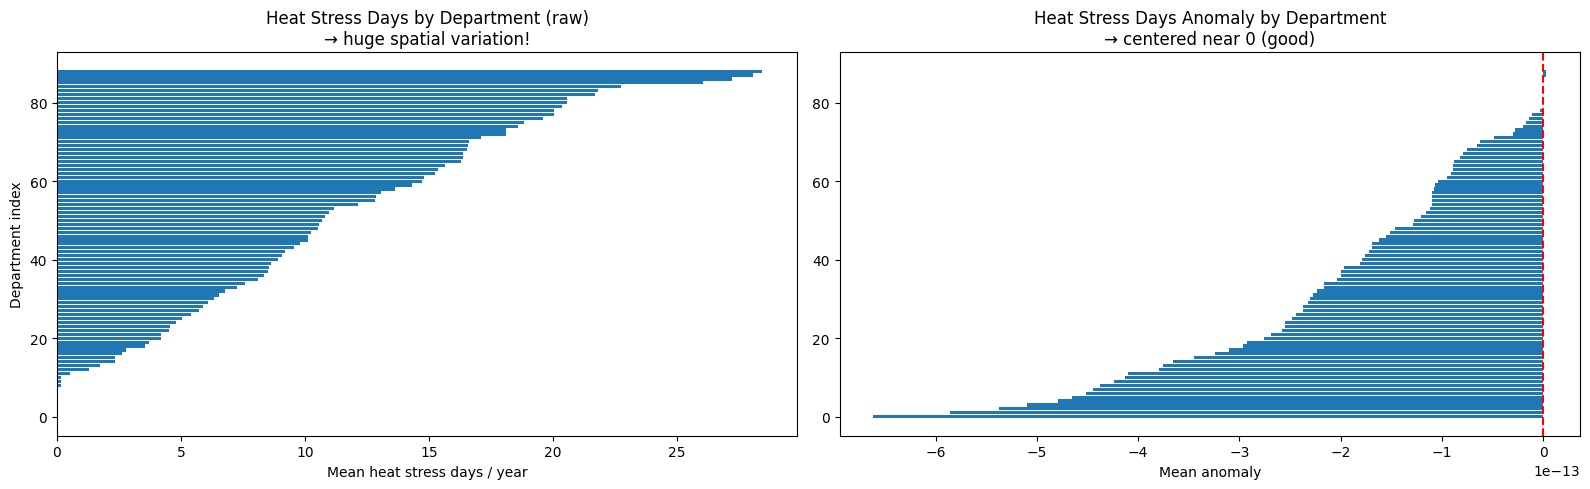


修复: 用省内标准化 (Z-score) 定义极端事件

事件                     频次       占比           产量异常      歉收率      正常歉收率       差异
----------------------------------------------------------------------------
极端高温(省内)              320   10.9%        +0.087 t/ha   11.6%     16.4%   -4.9%
持续干旱(省内)              307   10.5%        +0.139 t/ha   12.4%     16.3%   -3.9%
春季晚霜(省内)              283    9.6%        +0.104 t/ha    7.4%     16.8%   -9.4%
强降水(省内)               338   11.5%        +0.079 t/ha    9.5%     16.8%   -7.3%
热浪(省内)                320   10.9%        +0.018 t/ha   15.9%     15.9%   +0.0%

Sanity Check: 固定效应面板回归


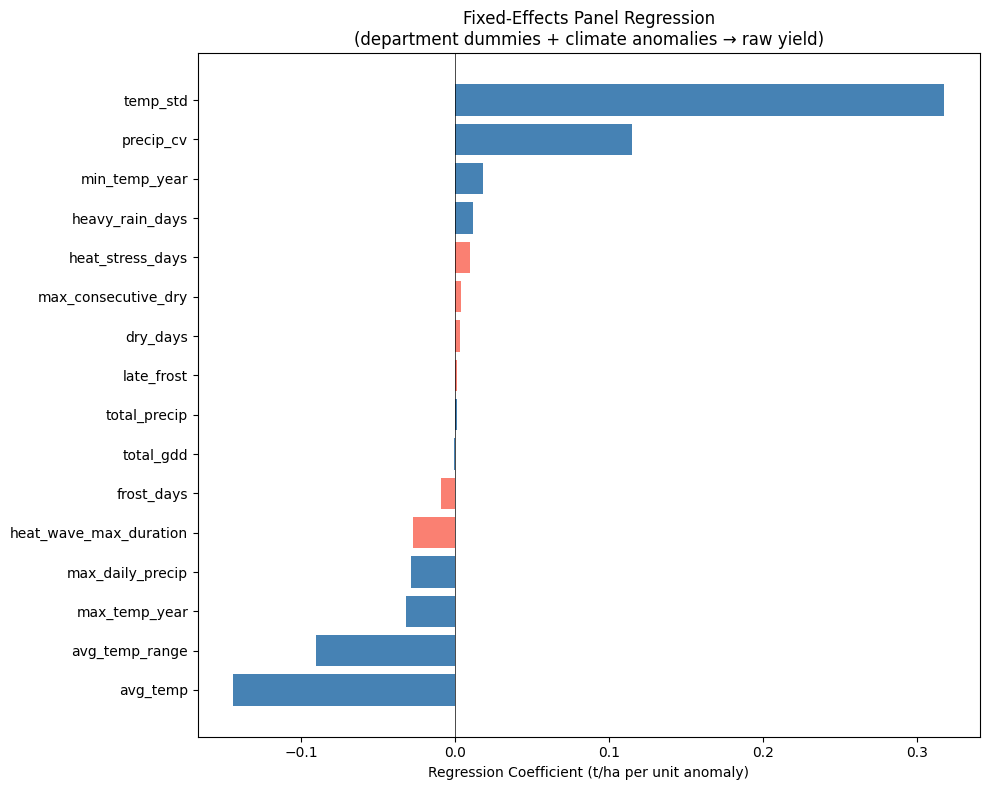


关键系数:
  heat_stress_days          = +0.0098 t/ha per unit
  max_consecutive_dry       = +0.0035 t/ha per unit
  late_frost                = +0.0015 t/ha per unit
  total_precip              = +0.0009 t/ha per unit
  total_gdd                 = -0.0005 t/ha per unit

修复: RF 用 GroupKFold + 省份编码
RF GroupKFold R² (leave-departments-out): 0.405 ± 0.059
RF GroupKFold R² (no dept code):          0.408 ± 0.060
RF normal 5-fold R² (original):           0.402 ± 0.022

→ 如果 GroupKFold 大幅下降，说明模型学的主要是'哪个省'而非'天气怎样影响产量'


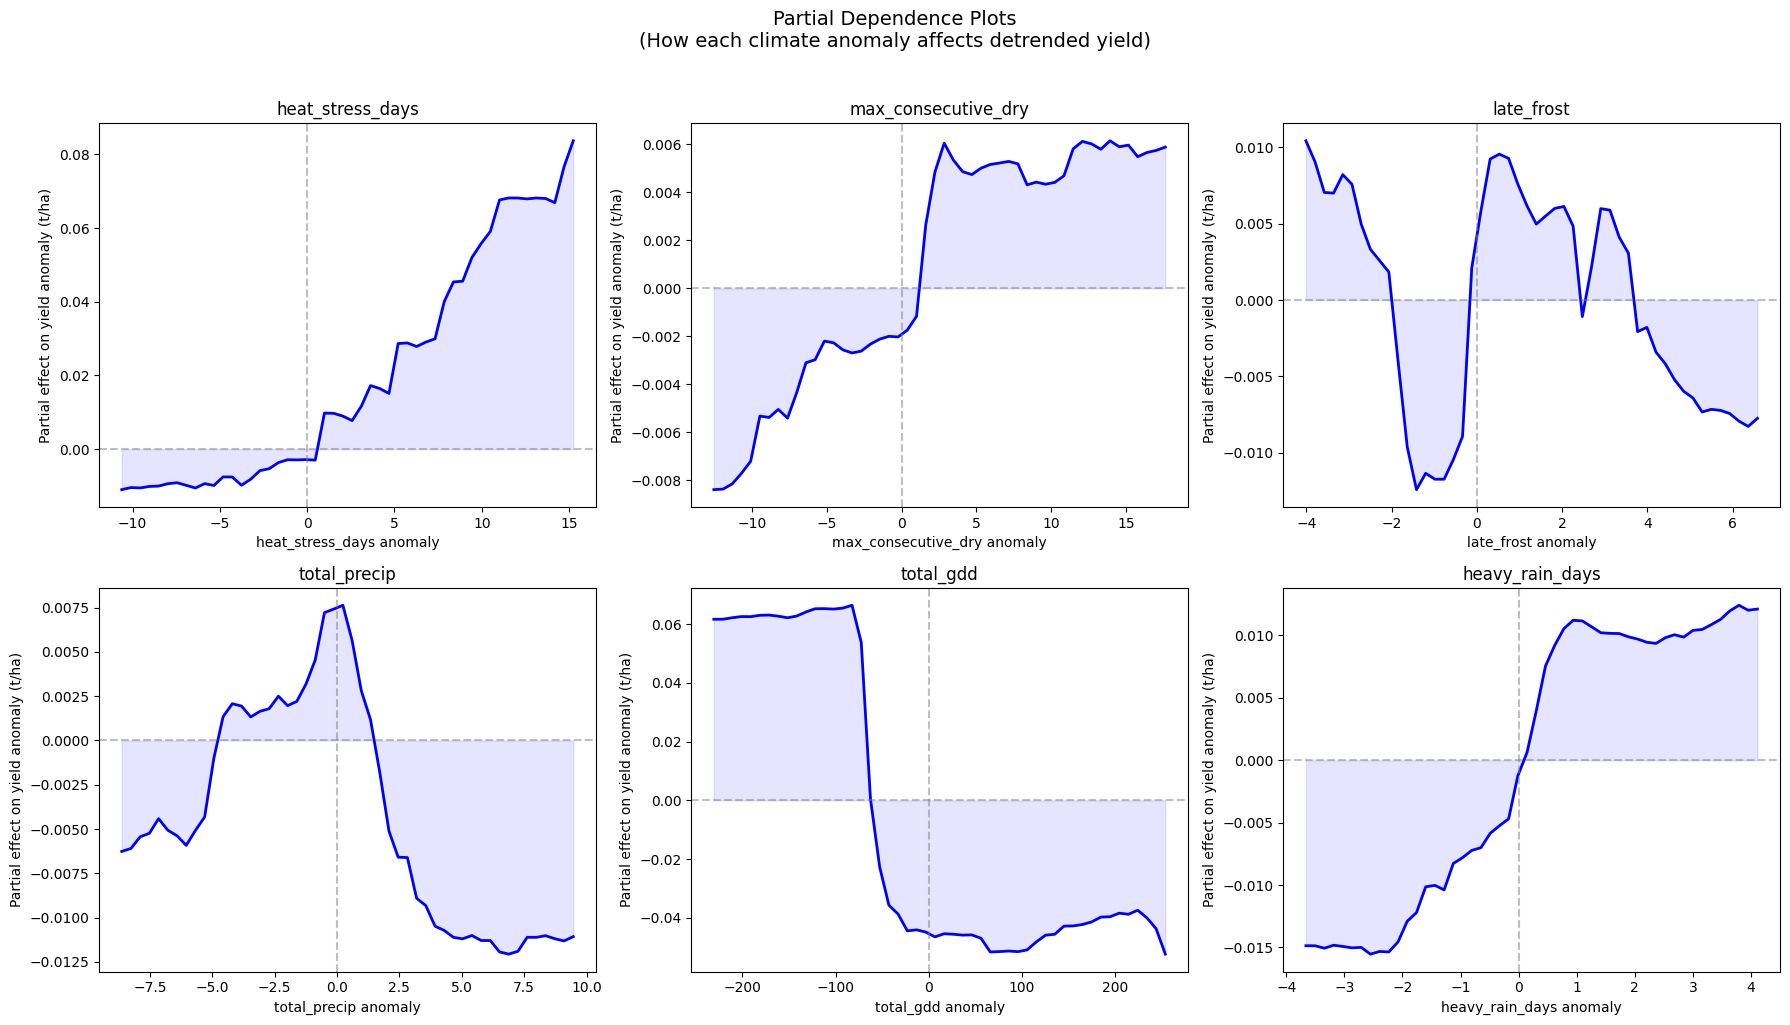


复合事件分析（省内标准化）

组合                        N           产量异常        歉收率
------------------------------------------------------
正常年份                   1543        -0.070 t/ha     20.1%
仅高温                     336        +0.049 t/ha     10.7%
仅干旱                     311        +0.083 t/ha     15.1%
高温+干旱                   114        +0.150 t/ha     11.4%
仅晚霜                     314        +0.106 t/ha      7.3%
仅强降水                    373        +0.050 t/ha     11.0%

修复后的风险场景（基于实际极端分布）

场景                      N         RF预测异常           实际异常
--------------------------------------------------------
严重高温年                 245        +0.347 t/ha        +0.122 t/ha
严重干旱年                 257        +0.065 t/ha        +0.161 t/ha
严重晚霜年                 235        -0.004 t/ha        +0.098 t/ha
高温+干旱                 114        +0.271 t/ha        +0.150 t/ha
实际严重歉收年               250        +0.104 t/ha        -1.169 t/ha

总结

问题根源:
1. 用全局分位数定义'极端' → 选出的是'本来就热/干的南方省'，不是'异常天气'
2. 南方省产量不一定低 → 出现'极端高温→产

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.inspection import partial_dependence
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ================================================================
# 诊断 1: 看一下之前的阈值选了哪些省
# ================================================================
print("=" * 60)
print("诊断: 全局 90th 分位数选出的'极端高温'事件来自哪些省？")
print("=" * 60)
mask_heat = df['heat_stress_days'] > df['heat_stress_days'].quantile(0.90)
print(df.loc[mask_heat, 'department'].value_counts().head(10))
print(f"\n占比最高的 5 个省贡献了 {df.loc[mask_heat, 'department'].value_counts().head(5).sum() / mask_heat.sum():.0%} 的'极端'事件")
print("→ 这不是'极端天气'，是'本来就热的地方'\n")

# ================================================================
# 诊断 2: 原始 vs 去趋势变量的省间差异
# ================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
dept_means = df.groupby('department')['heat_stress_days'].mean().sort_values()
axes[0].barh(range(len(dept_means)), dept_means.values, height=0.8)
axes[0].set_title('Heat Stress Days by Department (raw)\n→ huge spatial variation!')
axes[0].set_xlabel('Mean heat stress days / year')
axes[0].set_ylabel('Department index')

dept_means_anom = df.groupby('department')['heat_stress_days_anom'].mean().sort_values()
axes[1].barh(range(len(dept_means_anom)), dept_means_anom.values, height=0.8)
axes[1].set_title('Heat Stress Days Anomaly by Department\n→ centered near 0 (good)')
axes[1].set_xlabel('Mean anomaly')
axes[1].axvline(0, color='red', ls='--')
plt.tight_layout()
plt.show()

# ================================================================
# 修复 1: 用省内 Z-score 定义极端事件
# ================================================================
print("\n" + "=" * 60)
print("修复: 用省内标准化 (Z-score) 定义极端事件")
print("=" * 60)

# 每个变量在省内标准化
extreme_vars = ['heat_stress_days', 'max_consecutive_dry', 'late_frost',
                'heavy_rain_days', 'heat_wave_max_duration']

for var in extreme_vars:
    df[var + '_z'] = df.groupby('department')[var].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# 用 z > 1.28 (约 90th percentile within each department)
thresholds_fixed = {
    '极端高温(省内)':   df['heat_stress_days_z'] > 1.28,
    '持续干旱(省内)':   df['max_consecutive_dry_z'] > 1.28,
    '春季晚霜(省内)':   df['late_frost_z'] > 1.28,
    '强降水(省内)':     df['heavy_rain_days_z'] > 1.28,
    '热浪(省内)':       df['heat_wave_max_duration_z'] > 1.28,
}

print(f"\n{'事件':<18} {'频次':>6} {'占比':>8} {'产量异常':>14} {'歉收率':>8} {'正常歉收率':>10} {'差异':>8}")
print("-" * 76)
for name, mask in thresholds_fixed.items():
    n = mask.sum()
    if n == 0:
        continue
    anom = df.loc[mask, 'yield_detrended'].mean()
    bad  = df.loc[mask, 'is_bad_year'].mean()
    norm = df.loc[~mask, 'is_bad_year'].mean()
    diff = bad - norm
    print(f"{name:<18} {n:>6} {n/len(df):>7.1%} {anom:>+13.3f} t/ha {bad:>7.1%} {norm:>9.1%} {diff:>+7.1%}")

# ================================================================
# 修复 2: 简单面板回归做 sanity check
# ================================================================
print("\n" + "=" * 60)
print("Sanity Check: 固定效应面板回归")
print("=" * 60)

anom_features = [f + '_anom' for f in [
    'avg_temp', 'total_precip', 'total_gdd',
    'heat_stress_days', 'heat_wave_max_duration', 'max_temp_year',
    'frost_days', 'late_frost', 'min_temp_year',
    'dry_days', 'max_consecutive_dry', 'heavy_rain_days', 'max_daily_precip', 'precip_cv',
    'temp_std', 'avg_temp_range'
]]

# 省份 one-hot（固定效应）
dept_dummies = pd.get_dummies(df['department'], prefix='dept', drop_first=True)
X_fe = pd.concat([df[anom_features].fillna(0), dept_dummies], axis=1)
y_raw = df['yield']

lr = LinearRegression()
lr.fit(X_fe, y_raw)

# 只看气候变量的系数
coef_climate = pd.Series(lr.coef_[:len(anom_features)], index=anom_features)
coef_climate = coef_climate.sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['salmon' if 'heat' in f or 'dry' in f or 'frost' in f else 'steelblue'
          for f in coef_climate.index]
ax.barh(range(len(coef_climate)),
        coef_climate.values, color=colors)
ax.set_yticks(range(len(coef_climate)))
ax.set_yticklabels([f.replace('_anom', '') for f in coef_climate.index])
ax.axvline(0, color='black', lw=0.5)
ax.set_xlabel('Regression Coefficient (t/ha per unit anomaly)')
ax.set_title('Fixed-Effects Panel Regression\n(department dummies + climate anomalies → raw yield)')
plt.tight_layout()
plt.show()

print("\n关键系数:")
for feat in ['heat_stress_days_anom', 'max_consecutive_dry_anom',
             'late_frost_anom', 'total_precip_anom', 'total_gdd_anom']:
    print(f"  {feat.replace('_anom',''):<25} = {coef_climate[feat]:+.4f} t/ha per unit")

# ================================================================
# 修复 3: RF 用 GroupKFold (按省分组) 避免空间泄漏
# ================================================================
print("\n" + "=" * 60)
print("修复: RF 用 GroupKFold + 省份编码")
print("=" * 60)

# 加入省份编码
df['dept_code'] = df['department'].astype('category').cat.codes
X_rf = df[anom_features + ['dept_code']].fillna(0)
y_det = df['yield_detrended']

# GroupKFold 按省分组
groups = df['department']
gkf = GroupKFold(n_splits=5)

rf2 = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
scores_group = cross_val_score(rf2, X_rf, y_det, cv=gkf, groups=groups, scoring='r2')
print(f"RF GroupKFold R² (leave-departments-out): {scores_group.mean():.3f} ± {scores_group.std():.3f}")

# 也试不加 dept_code
rf3 = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
scores_nodept = cross_val_score(rf3, df[anom_features].fillna(0), y_det,
                                cv=gkf, groups=groups, scoring='r2')
print(f"RF GroupKFold R² (no dept code):          {scores_nodept.mean():.3f} ± {scores_nodept.std():.3f}")

# 用普通 CV 对比
rf4 = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
scores_normal = cross_val_score(rf4, df[anom_features].fillna(0), y_det, cv=5, scoring='r2')
print(f"RF normal 5-fold R² (original):           {scores_normal.mean():.3f} ± {scores_normal.std():.3f}")
print("\n→ 如果 GroupKFold 大幅下降，说明模型学的主要是'哪个省'而非'天气怎样影响产量'")

# ================================================================
# 修复 4: Partial Dependence Plots（关键变量）
# ================================================================
rf_final = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf_final.fit(df[anom_features].fillna(0), y_det)

key_feats = ['heat_stress_days_anom', 'max_consecutive_dry_anom',
             'late_frost_anom', 'total_precip_anom', 'total_gdd_anom',
             'heavy_rain_days_anom']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, feat in zip(axes.ravel(), key_feats):
    feat_idx = anom_features.index(feat)
    pdp = partial_dependence(rf_final, df[anom_features].fillna(0),
                             features=[feat_idx], kind='average',
                             grid_resolution=50)
    ax.plot(pdp['grid_values'][0], pdp['average'][0], 'b-', lw=2)
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(feat.replace('_anom', ' anomaly'))
    ax.set_ylabel('Partial effect on yield anomaly (t/ha)')
    ax.set_title(feat.replace('_anom', ''))
    ax.fill_between(pdp['grid_values'][0], pdp['average'][0],
                    alpha=0.1, color='blue')

plt.suptitle('Partial Dependence Plots\n(How each climate anomaly affects detrended yield)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# 修复 5: 复合事件交互分析
# ================================================================
print("\n" + "=" * 60)
print("复合事件分析（省内标准化）")
print("=" * 60)

hot = df['heat_stress_days_z'] > 1.0
dry = df['max_consecutive_dry_z'] > 1.0
frost_late = df['late_frost_z'] > 1.0
wet = df['heavy_rain_days_z'] > 1.0

combos = {
    '正常年份':                 ~hot & ~dry & ~frost_late & ~wet,
    '仅高温':                   hot & ~dry,
    '仅干旱':                   ~hot & dry,
    '高温+干旱':                hot & dry,
    '仅晚霜':                   frost_late & ~hot & ~dry,
    '仅强降水':                 wet & ~hot & ~dry,
}

print(f"\n{'组合':<20} {'N':>6} {'产量异常':>14} {'歉收率':>10}")
print("-" * 54)
for name, mask in combos.items():
    n = mask.sum()
    if n < 5:
        continue
    anom = df.loc[mask, 'yield_detrended'].mean()
    bad  = df.loc[mask, 'is_bad_year'].mean()
    print(f"{name:<20} {n:>6} {anom:>+13.3f} t/ha {bad:>9.1%}")

# ================================================================
# 修复后的风险场景
# ================================================================
print("\n" + "=" * 60)
print("修复后的风险场景（基于实际极端分布）")
print("=" * 60)

# 用实际极端年份的平均气候异常作为场景
def extreme_scenario(condition, name):
    sub = df.loc[condition, anom_features].mean()
    pred = rf_final.predict(sub.values.reshape(1, -1))[0]
    n = condition.sum()
    actual = df.loc[condition, 'yield_detrended'].mean()
    return name, n, pred, actual

scenarios_v2 = [
    (df['heat_stress_days_z'] > 1.5, '严重高温年'),
    (df['max_consecutive_dry_z'] > 1.5, '严重干旱年'),
    (df['late_frost_z'] > 1.5, '严重晚霜年'),
    ((df['heat_stress_days_z'] > 1.0) & (df['max_consecutive_dry_z'] > 1.0), '高温+干旱'),
    (df['yield_detrend_z'] < -1.5, '实际严重歉收年'),
]

print(f"\n{'场景':<18} {'N':>6} {'RF预测异常':>14} {'实际异常':>14}")
print("-" * 56)
for cond, name in scenarios_v2:
    if cond.sum() < 3:
        continue
    name, n, pred, actual = extreme_scenario(cond, name)
    print(f"{name:<18} {n:>6} {pred:>+13.3f} t/ha {actual:>+13.3f} t/ha")

print("\n" + "=" * 60)
print("总结")
print("=" * 60)
print("""
问题根源:
1. 用全局分位数定义'极端' → 选出的是'本来就热/干的南方省'，不是'异常天气'
2. 南方省产量不一定低 → 出现'极端高温→产量反而高'的假象
3. RF 的普通 CV 可能有空间泄漏（同省数据在训练和测试都出现）

修复方法:
1. ✅ 用省内 Z-score 定义极端（每个省跟自己历史比）
2. ✅ 用 GroupKFold 按省分组验证
3. ✅ Partial Dependence Plot 看真实学到的关系
4. ✅ 固定效应回归做 sanity check

→ 看修复后的结果，极端事件的影响方向应该更合理了
""")

诊断：线性去趋势是否充分
year ↔ yield_detrended:      r = -0.0000
year ↔ heat_stress_days_anom: r = -0.0000
→ 如果不接近 0，说明线性去趋势有残留趋势



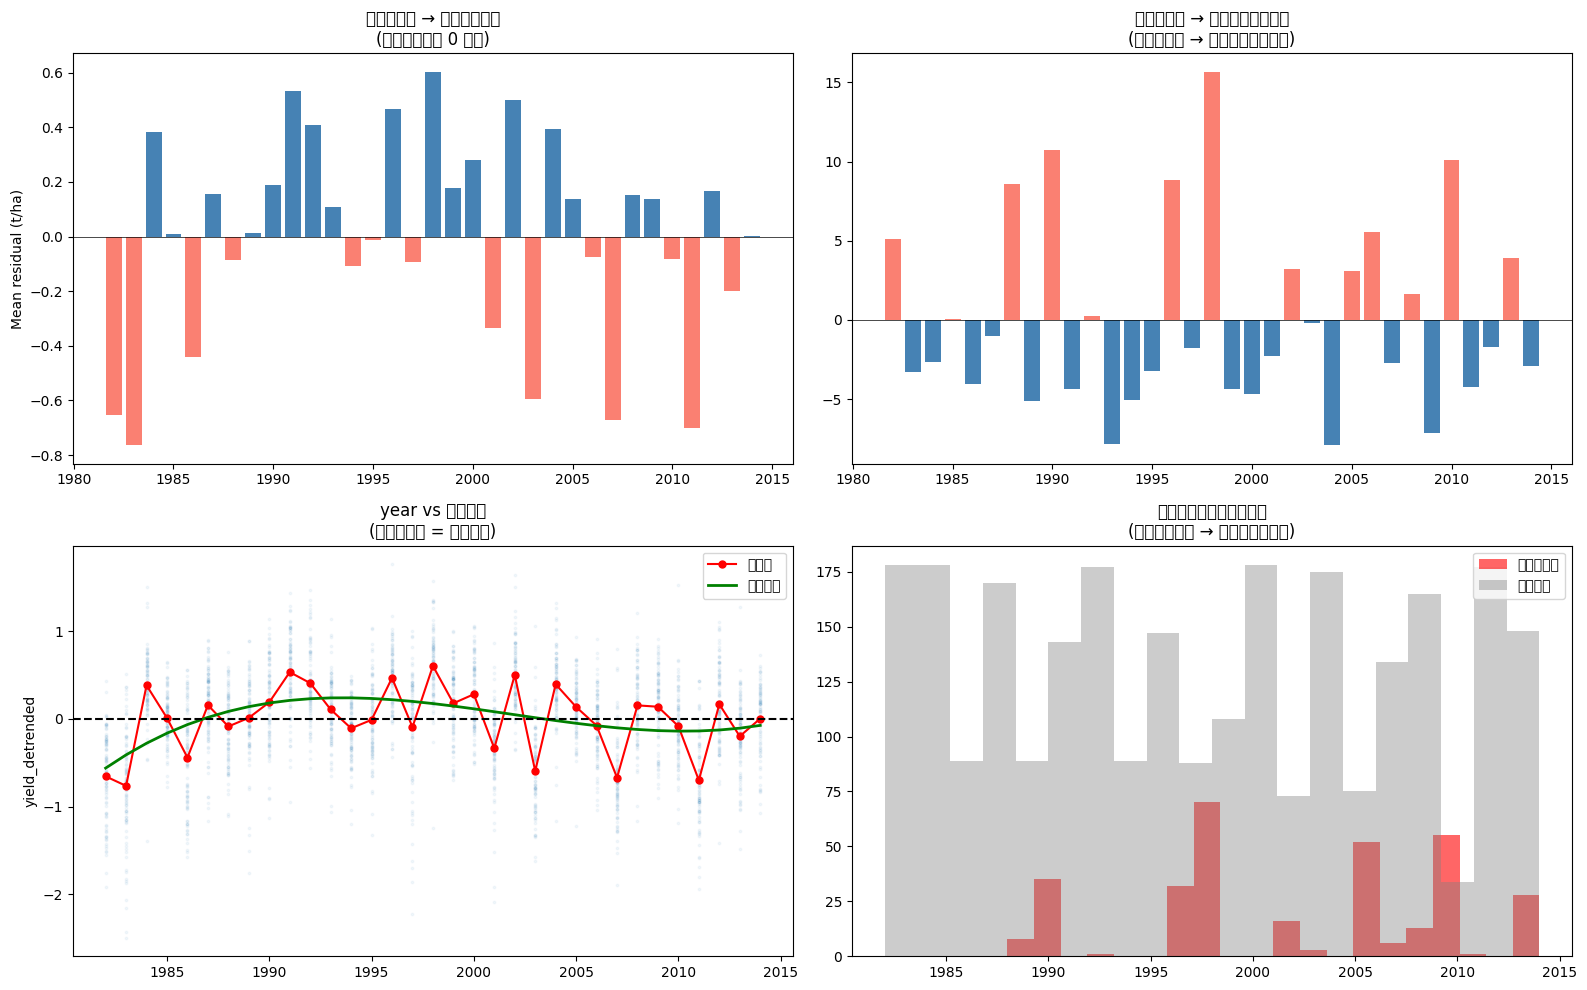


方案 A：三次多项式去趋势
year ↔ yield_p3: r = -0.0000

方案 B：一阶差分 ΔY ~ ΔX
差分样本量: 2846
year ↔ yield_d1: r = -0.0462

方案 C：省 + 年 双向固定效应
year ↔ yield_twfe: r = 0.0009


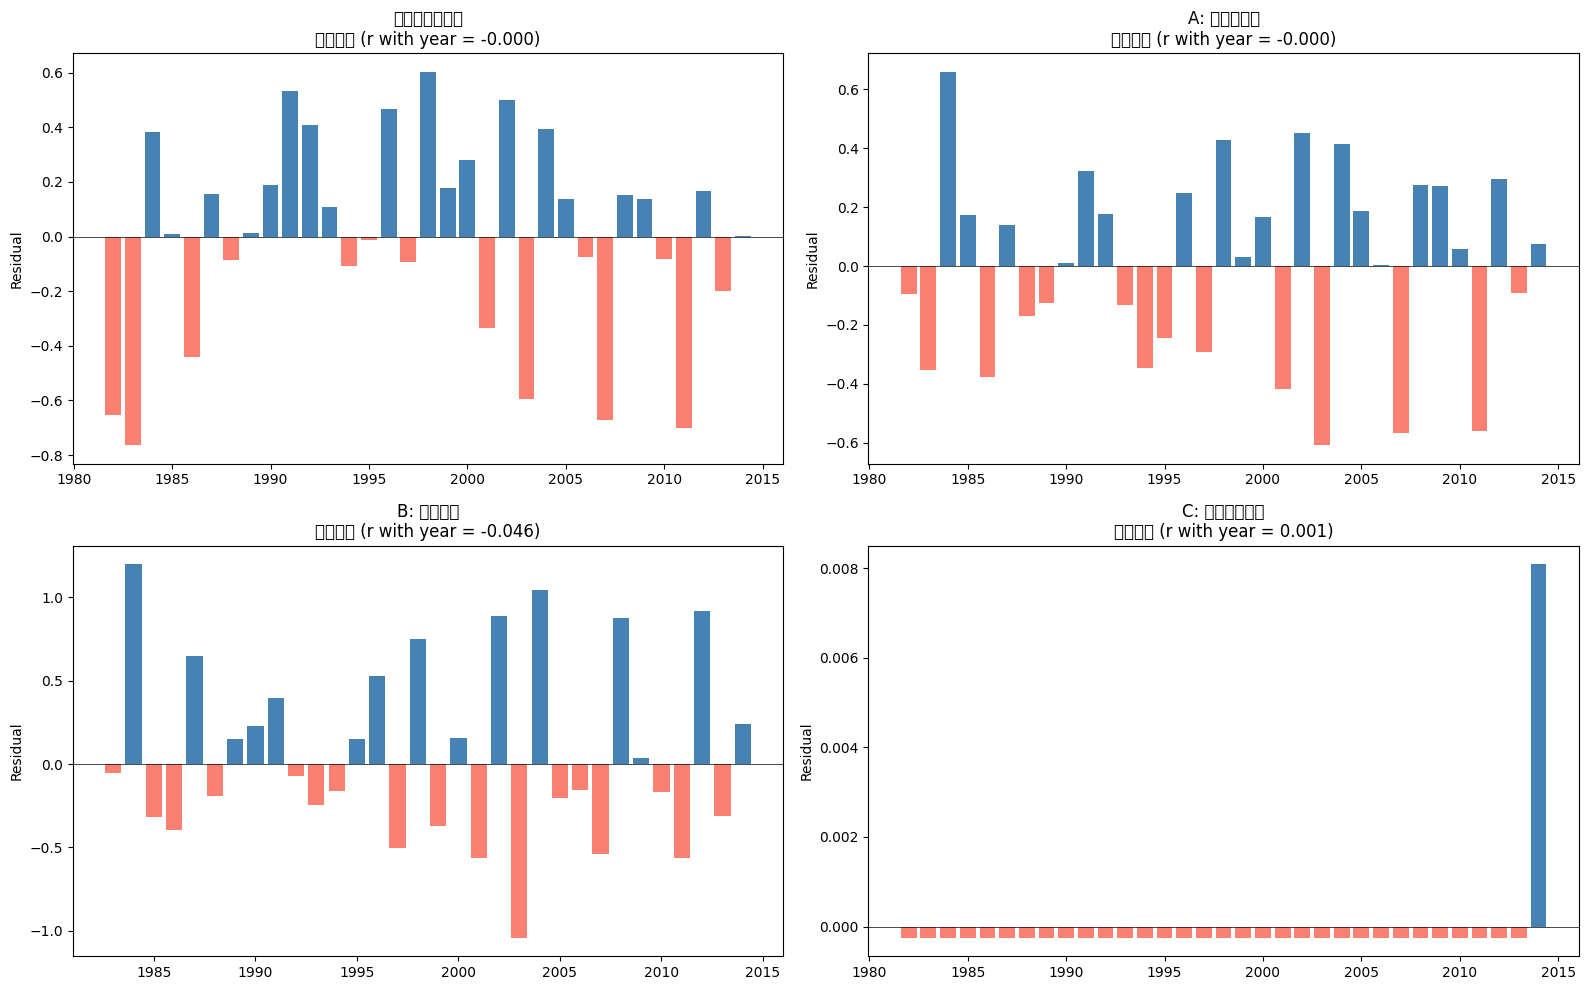


极端事件影响对比（四种去趋势方案）

--- 线性 ---
  高温     N= 320  Δyield = +0.097 t/ha  p=0.004 ***
  干旱     N= 307  Δyield = +0.155 t/ha  p=0.000 ***
  晚霜     N= 283  Δyield = +0.115 t/ha  p=0.001 ***
  暴雨     N= 338  Δyield = +0.089 t/ha  p=0.008 ***

--- 三次多项式 ---
  高温     N= 320  Δyield = +0.068 t/ha  p=0.027 **
  干旱     N= 307  Δyield = +0.082 t/ha  p=0.009 ***
  晚霜     N= 283  Δyield = -0.115 t/ha  p=0.000 ***
  暴雨     N= 338  Δyield = +0.056 t/ha  p=0.062 *

--- 一阶差分 ---
  高温     N= 320  Δyield = +0.050 t/ha  p=0.298 
  干旱     N= 299  Δyield = +0.099 t/ha  p=0.045 **
  晚霜     N= 283  Δyield = -0.032 t/ha  p=0.526 
  暴雨     N= 336  Δyield = +0.079 t/ha  p=0.090 *

--- 双向FE ---
  高温     N= 320  Δyield = -0.109 t/ha  p=0.000 ***
  干旱     N= 307  Δyield = -0.029 t/ha  p=0.319 
  晚霜     N= 283  Δyield = -0.022 t/ha  p=0.476 
  暴雨     N= 338  Δyield = +0.019 t/ha  p=0.499 


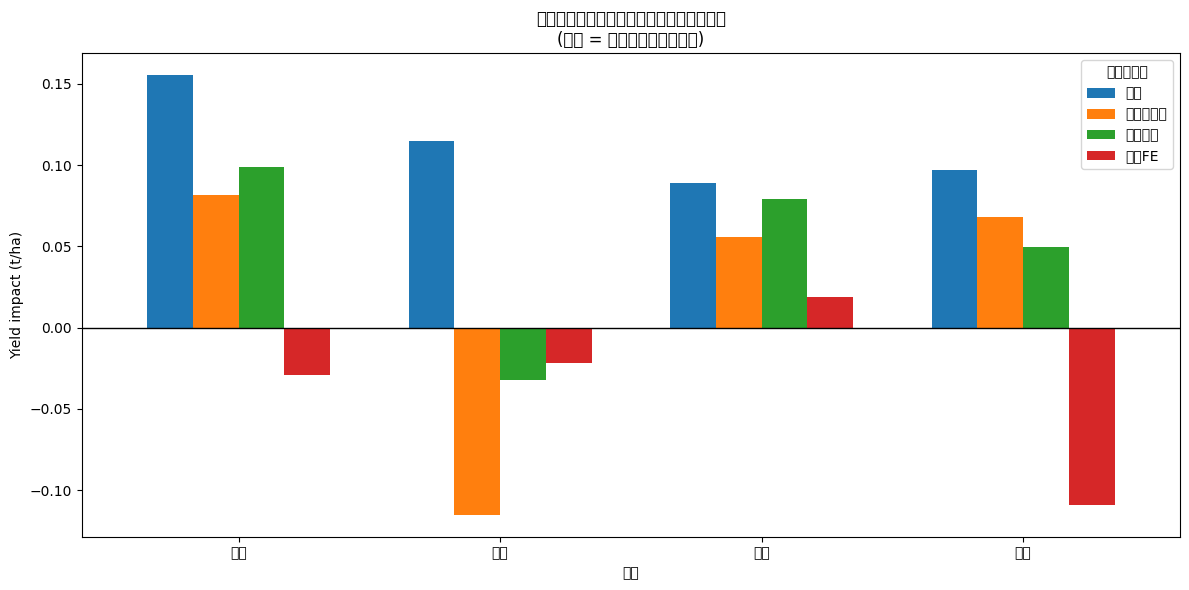

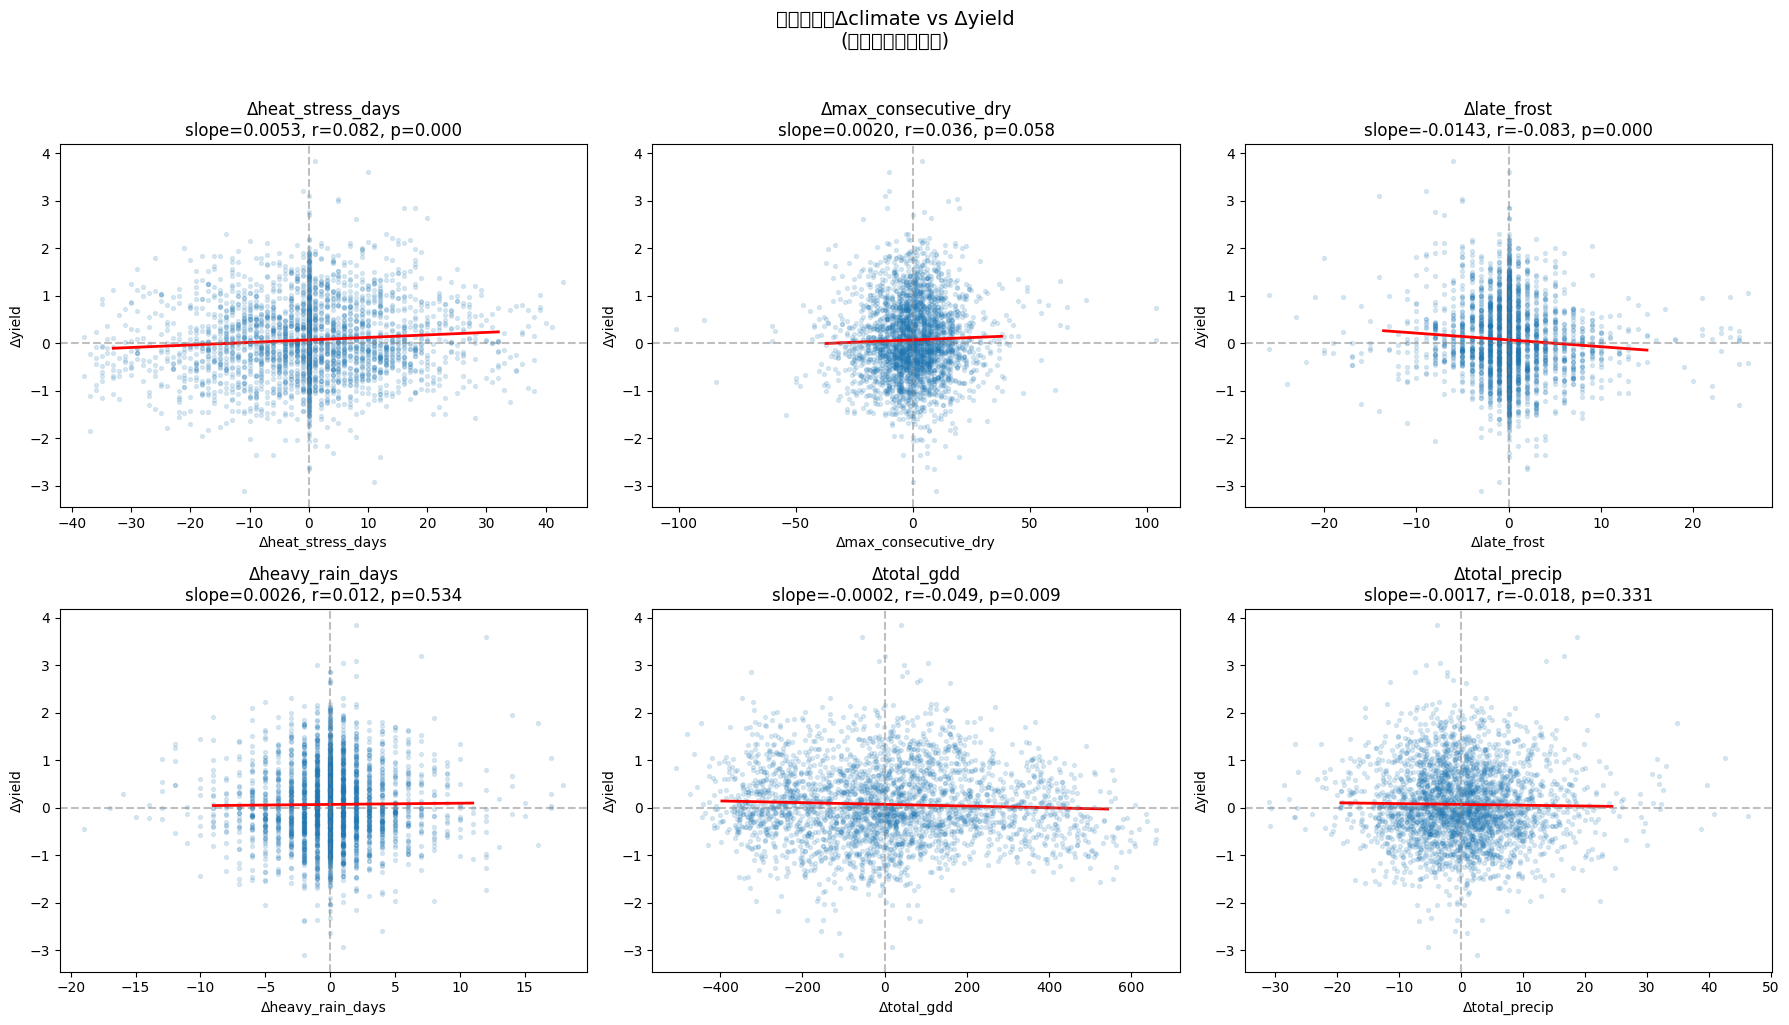

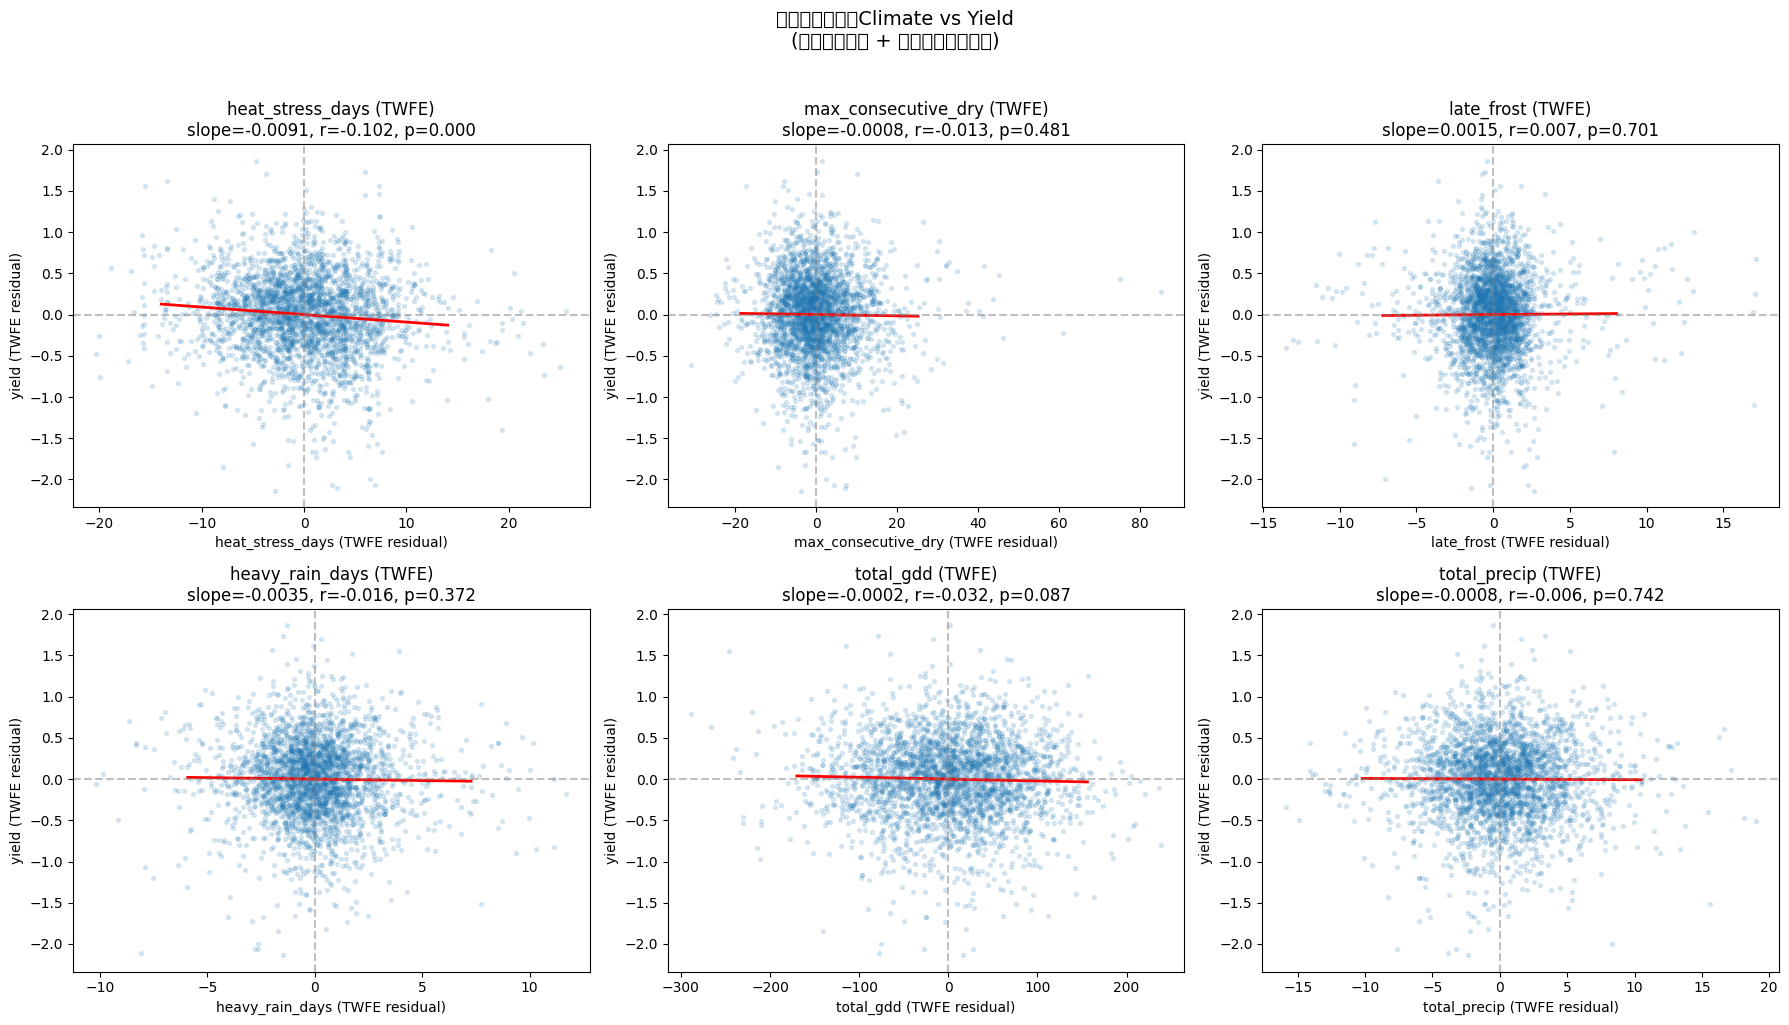


RF 模型对比
一阶差分  R²: 0.385 ± 0.034
双向FE   R²: 0.056 ± 0.014
三次多项式 R²: 0.311 ± 0.031


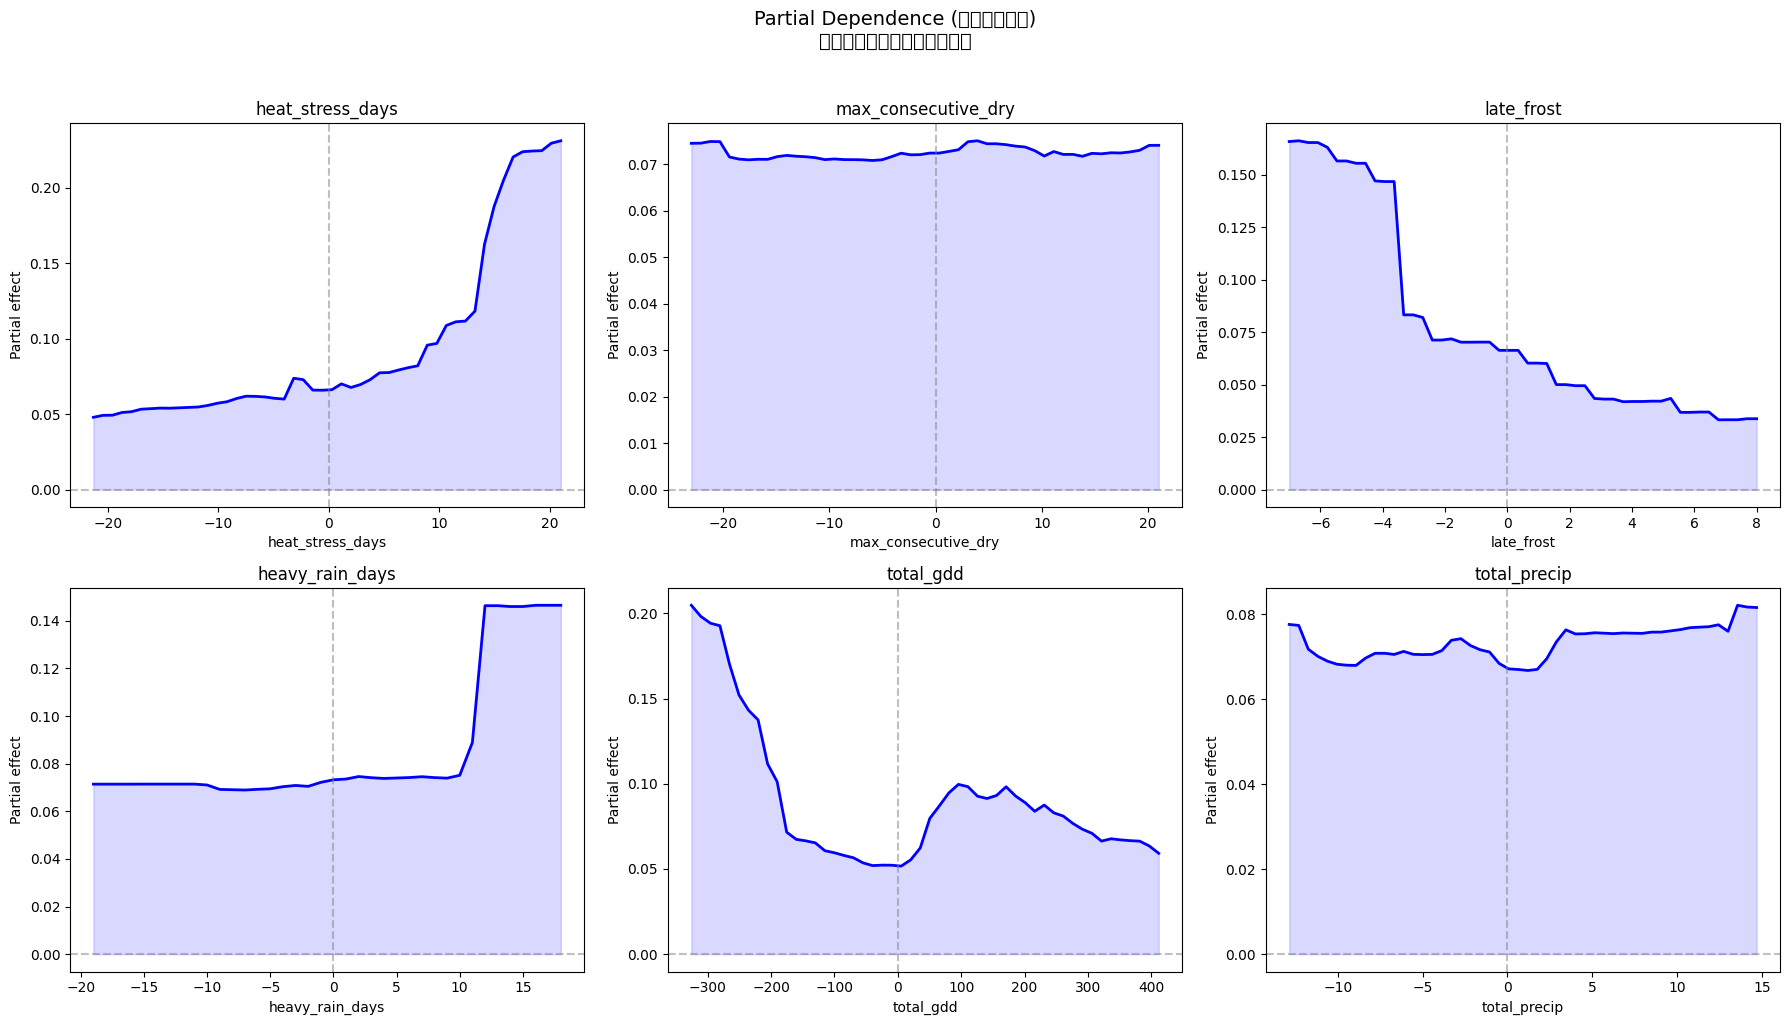


歉收年诊断：实际减产年发生了什么？
歉收年样本: 431,  丰收年样本: 438

气候变量                             歉收年均值        丰收年均值         差异     方向
----------------------------------------------------------------------
  avg_temp                       +0.001      -0.011    +0.012  ✗
  total_precip                   +0.222      +0.143    +0.079  ✗
  total_gdd                      +3.337      -4.277    +7.613  ✗
  heat_stress_days               +0.868      -0.574    +1.441  ✓
  heat_wave_max_duration         +0.290      -0.263    +0.553  ✓
  max_temp_year                  +0.090      -0.104    +0.194  ✗
  frost_days                     +0.566      +0.158    +0.408  ✓
  late_frost                     +0.191      +0.179    +0.012  ✓
  min_temp_year                  -0.156      +0.189    -0.345  ✗
  dry_days                       -0.111      -0.935    +0.824  ✓
  max_consecutive_dry            +0.160      +0.249    -0.089  ✗
  heavy_rain_days                +0.074      -0.040    +0.114  ✗
  max_daily_precip               +0

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence
import warnings
warnings.filterwarnings('ignore')

climate_features = [
    'avg_temp', 'total_precip', 'total_gdd',
    'heat_stress_days', 'heat_wave_max_duration', 'max_temp_year',
    'frost_days', 'late_frost', 'min_temp_year',
    'dry_days', 'max_consecutive_dry', 'heavy_rain_days', 'max_daily_precip', 'precip_cv',
    'temp_std', 'avg_temp_range'
]

# ================================================================
# 诊断：线性去趋势后残差是否还有时间模式
# ================================================================
print("=" * 60)
print("诊断：线性去趋势是否充分")
print("=" * 60)

r1 = df['year'].corr(df['yield_detrended'])
r2 = df['year'].corr(df['heat_stress_days_anom'])
print(f"year ↔ yield_detrended:      r = {r1:.4f}")
print(f"year ↔ heat_stress_days_anom: r = {r2:.4f}")
print("→ 如果不接近 0，说明线性去趋势有残留趋势\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 每年平均残差
yr_resid = df.groupby('year')['yield_detrended'].mean()
axes[0, 0].bar(yr_resid.index, yr_resid.values,
               color=['salmon' if v < 0 else 'steelblue' for v in yr_resid.values])
axes[0, 0].axhline(0, color='black', lw=0.5)
axes[0, 0].set_title('线性去趋势 → 每年平均残差\n(应随机分布在 0 附近)')
axes[0, 0].set_ylabel('Mean residual (t/ha)')

# 每年平均高温异常
yr_heat = df.groupby('year')['heat_stress_days_anom'].mean()
axes[0, 1].bar(yr_heat.index, yr_heat.values,
               color=['salmon' if v > 0 else 'steelblue' for v in yr_heat.values])
axes[0, 1].axhline(0, color='black', lw=0.5)
axes[0, 1].set_title('线性去趋势 → 每年平均高温异常\n(若趋势明显 → 气候去趋势也不够)')

# scatter: year vs yield_detrended + cubic fit
axes[1, 0].scatter(df['year'], df['yield_detrended'], alpha=0.05, s=3)
x_yr = np.sort(df['year'].unique()).astype(float)
y_mean = np.array([df.loc[df['year'] == y, 'yield_detrended'].mean() for y in x_yr])
axes[1, 0].plot(x_yr, y_mean, 'ro-', ms=5, label='年均值')
if len(x_yr) > 4:
    z3 = np.polyfit(x_yr, y_mean, 3)
    axes[1, 0].plot(x_yr, np.polyval(z3, x_yr), 'g-', lw=2, label='三次拟合')
axes[1, 0].axhline(0, color='black', ls='--')
axes[1, 0].legend()
axes[1, 0].set_title('year vs 线性残差\n(有明显弯曲 = 线性不够)')
axes[1, 0].set_ylabel('yield_detrended')

# 极端事件年份分布
axes[1, 1].hist(df.loc[df['heat_stress_days_z'] > 1.28, 'year'], bins=20,
                alpha=0.6, label='高温极端年', color='red')
axes[1, 1].hist(df.loc[df['heat_stress_days_z'] <= 1.28, 'year'], bins=20,
                alpha=0.4, label='非极端年', color='gray')
axes[1, 1].legend()
axes[1, 1].set_title('极端高温事件的年份分布\n(若集中在近年 → 与残留趋势混淆)')

plt.tight_layout()
plt.show()

# ================================================================
# 方案 A：三次多项式去趋势
# ================================================================
print("\n" + "=" * 60)
print("方案 A：三次多项式去趋势")
print("=" * 60)

def detrend_poly3_all(group):
    g = group.copy()
    x = g['year'].values.astype(float)
    # yield
    y = g['yield'].values.astype(float)
    if len(x) >= 5:
        g['yield_p3'] = y - np.polyval(np.polyfit(x, y, 3), x)
    else:
        g['yield_p3'] = y - np.mean(y)
    # climate
    for col in climate_features:
        yc = g[col].values.astype(float)
        if len(x) >= 5 and np.nanstd(yc) > 0:
            mask = np.isfinite(yc)
            coeffs = np.polyfit(x[mask], yc[mask], 3)
            g[col + '_p3'] = yc - np.polyval(coeffs, x)
        else:
            g[col + '_p3'] = yc - np.nanmean(yc)
    return g

df = df.groupby('department', group_keys=False).apply(detrend_poly3_all)
print(f"year ↔ yield_p3: r = {df['year'].corr(df['yield_p3']):.4f}")

# ================================================================
# 方案 B：一阶差分 (最稳健，消除任何平滑趋势)
# ================================================================
print("\n" + "=" * 60)
print("方案 B：一阶差分 ΔY ~ ΔX")
print("=" * 60)

df = df.sort_values(['department', 'year'])
for col in ['yield'] + climate_features:
    df[col + '_d1'] = df.groupby('department')[col].diff()

df_d1 = df.dropna(subset=['yield_d1']).copy()
print(f"差分样本量: {len(df_d1)}")
print(f"year ↔ yield_d1: r = {df_d1['year'].corr(df_d1['yield_d1']):.4f}")

# ================================================================
# 方案 C：省 + 年 双向固定效应
# ================================================================
print("\n" + "=" * 60)
print("方案 C：省 + 年 双向固定效应")
print("=" * 60)

for col in ['yield'] + climate_features:
    dept_m = df.groupby('department')[col].transform('mean')
    year_m = df.groupby('year')[col].transform('mean')
    total_m = df[col].mean()
    df[col + '_twfe'] = df[col] - dept_m - year_m + total_m

print(f"year ↔ yield_twfe: r = {df['year'].corr(df['yield_twfe']):.4f}")

# ================================================================
# 每种方案的每年平均残差可视化
# ================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, (label, col) in zip(axes.ravel(), [
    ('原始线性去趋势', 'yield_detrended'),
    ('A: 三次多项式', 'yield_p3'),
    ('B: 一阶差分', 'yield_d1'),
    ('C: 双向固定效应', 'yield_twfe'),
]):
    src = df_d1 if 'd1' in col else df
    yr_m = src.groupby('year')[col].mean()
    ax.bar(yr_m.index, yr_m.values,
           color=['salmon' if v < 0 else 'steelblue' for v in yr_m.values])
    ax.axhline(0, color='black', lw=0.5)
    r = src['year'].corr(src[col])
    ax.set_title(f'{label}\n年均残差 (r with year = {r:.3f})')
    ax.set_ylabel('Residual')
plt.tight_layout()
plt.show()

# ================================================================
# 核心对比：极端事件对产量的影响（四种方案）
# ================================================================
print("\n" + "=" * 60)
print("极端事件影响对比（四种去趋势方案）")
print("=" * 60)

# 用省内 z-score 定义极端（已有）
extreme_defs = {
    '高温': 'heat_stress_days_z',
    '干旱': 'max_consecutive_dry_z',
    '晚霜': 'late_frost_z',
    '暴雨': 'heavy_rain_days_z',
}

approaches = [
    ('线性', df, 'yield_detrended'),
    ('三次多项式', df, 'yield_p3'),
    ('一阶差分', df_d1, 'yield_d1'),
    ('双向FE', df, 'yield_twfe'),
]

results = []
for appr_name, data, ycol in approaches:
    for evt_name, zcol in extreme_defs.items():
        if zcol not in data.columns:
            continue
        mask = data[zcol] > 1.28
        n = mask.sum()
        if n < 5:
            continue
        ext_vals = data.loc[mask, ycol].dropna()
        nrm_vals = data.loc[~mask, ycol].dropna()
        diff = ext_vals.mean() - nrm_vals.mean()
        t, p = stats.ttest_ind(ext_vals, nrm_vals)
        results.append({
            '方案': appr_name, '事件': evt_name,
            'N': n, '产量差异': diff, 'p值': p
        })

res_df = pd.DataFrame(results)

# 打印
for appr in ['线性', '三次多项式', '一阶差分', '双向FE']:
    print(f"\n--- {appr} ---")
    sub = res_df[res_df['方案'] == appr]
    for _, row in sub.iterrows():
        sig = '***' if row['p值'] < 0.01 else '**' if row['p值'] < 0.05 else '*' if row['p值'] < 0.1 else ''
        print(f"  {row['事件']:<6} N={row['N']:>4}  Δyield = {row['产量差异']:>+.3f} t/ha  p={row['p值']:.3f} {sig}")

# 可视化对比
fig, ax = plt.subplots(figsize=(12, 6))
pivot = res_df.pivot(index='事件', columns='方案', values='产量差异')
pivot = pivot[['线性', '三次多项式', '一阶差分', '双向FE']]
pivot.plot(kind='bar', ax=ax, width=0.7)
ax.axhline(0, color='black', lw=1)
ax.set_ylabel('Yield impact (t/ha)')
ax.set_title('极端事件对产量影响：四种去趋势方案对比\n(负值 = 减产，才是合理方向)')
ax.legend(title='去趋势方案')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

# ================================================================
# 差分方案的散点图
# ================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
key_vars = ['heat_stress_days', 'max_consecutive_dry', 'late_frost',
            'heavy_rain_days', 'total_gdd', 'total_precip']

for ax, var in zip(axes.ravel(), key_vars):
    xcol = var + '_d1'
    ycol = 'yield_d1'
    if xcol not in df_d1.columns:
        continue
    x = df_d1[xcol].values.astype(float)
    y = df_d1[ycol].values.astype(float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.15, s=8)
    if len(x) > 2 and np.std(x) > 0:
        slope, intercept, r, p, se = stats.linregress(x, y)
        xl = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 100)
        ax.plot(xl, slope * xl + intercept, 'r-', lw=2)
        ax.set_title(f'Δ{var}\nslope={slope:.4f}, r={r:.3f}, p={p:.3f}')
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(f'Δ{var}')
    ax.set_ylabel('Δyield')

plt.suptitle('一阶差分：Δclimate vs Δyield\n(最干净的因果推断)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# 双向FE的散点图
# ================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var in zip(axes.ravel(), key_vars):
    xcol = var + '_twfe'
    ycol = 'yield_twfe'
    x = df[xcol].values.astype(float)
    y = df[ycol].values.astype(float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.15, s=8)
    if len(x) > 2 and np.std(x) > 0:
        slope, intercept, r, p, se = stats.linregress(x, y)
        xl = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 100)
        ax.plot(xl, slope * xl + intercept, 'r-', lw=2)
        ax.set_title(f'{var} (TWFE)\nslope={slope:.4f}, r={r:.3f}, p={p:.3f}')
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(f'{var} (TWFE residual)')
    ax.set_ylabel('yield (TWFE residual)')

plt.suptitle('双向固定效应：Climate vs Yield\n(消除省际差异 + 全国年际共同趋势)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# RF 用双向FE
# ================================================================
print("\n" + "=" * 60)
print("RF 模型对比")
print("=" * 60)

# 差分
d1_feats = [f + '_d1' for f in climate_features]
X_d1 = df_d1[d1_feats].fillna(0)
y_d1 = df_d1['yield_d1']
rf1 = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
sc1 = cross_val_score(rf1, X_d1, y_d1, cv=5, scoring='r2')

# TWFE
twfe_feats = [f + '_twfe' for f in climate_features]
X_twfe = df[twfe_feats].fillna(0)
y_twfe = df['yield_twfe']
rf2 = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
sc2 = cross_val_score(rf2, X_twfe, y_twfe, cv=5, scoring='r2')

# Poly3
p3_feats = [f + '_p3' for f in climate_features]
X_p3 = df[p3_feats].fillna(0)
y_p3 = df['yield_p3']
rf3 = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
sc3 = cross_val_score(rf3, X_p3, y_p3, cv=5, scoring='r2')

print(f"一阶差分  R²: {sc1.mean():.3f} ± {sc1.std():.3f}")
print(f"双向FE   R²: {sc2.mean():.3f} ± {sc2.std():.3f}")
print(f"三次多项式 R²: {sc3.mean():.3f} ± {sc3.std():.3f}")

# 选最好的方案做 PDP
best_data = df_d1 if sc1.mean() > sc2.mean() else df
best_feats = d1_feats if sc1.mean() > sc2.mean() else twfe_feats
best_ycol = 'yield_d1' if sc1.mean() > sc2.mean() else 'yield_twfe'
best_name = '一阶差分' if sc1.mean() > sc2.mean() else '双向FE'

X_best = best_data[best_feats].fillna(0)
y_best = best_data[best_ycol]
rf_best = RandomForestRegressor(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
rf_best.fit(X_best, y_best)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
suffix = '_d1' if best_name == '一阶差分' else '_twfe'
key_feats_best = [v + suffix for v in key_vars]

for ax, feat in zip(axes.ravel(), key_feats_best):
    feat_idx = best_feats.index(feat)
    pdp = partial_dependence(rf_best, X_best, features=[feat_idx],
                             kind='average', grid_resolution=50)
    ax.plot(pdp['grid_values'][0], pdp['average'][0], 'b-', lw=2)
    ax.fill_between(pdp['grid_values'][0], pdp['average'][0], alpha=0.15, color='blue')
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
    ax.set_xlabel(feat.replace(suffix, ''))
    ax.set_ylabel('Partial effect')
    ax.set_title(feat.replace(suffix, ''))

plt.suptitle(f'Partial Dependence ({best_name}方案)\n气候变量对产量的非线性效应',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# 歉收年诊断：到底什么导致减产？
# ================================================================
print("\n" + "=" * 60)
print("歉收年诊断：实际减产年发生了什么？")
print("=" * 60)

# 用 TWFE 定义歉收
df['yield_twfe_z'] = df.groupby('department')['yield_twfe'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

bad = df['yield_twfe_z'] < -1.0
good = df['yield_twfe_z'] > 1.0

print(f"歉收年样本: {bad.sum()},  丰收年样本: {good.sum()}\n")

print(f"{'气候变量':<25} {'歉收年均值':>12} {'丰收年均值':>12} {'差异':>10} {'方向':>6}")
print("-" * 70)
for var in climate_features:
    twfe_col = var + '_twfe'
    bad_m = df.loc[bad, twfe_col].mean()
    good_m = df.loc[good, twfe_col].mean()
    diff = bad_m - good_m
    direction = '✓' if (
        ('heat' in var and diff > 0) or
        ('dry' in var and diff > 0) or
        ('frost' in var and diff > 0) or
        ('precip' in var and diff < 0) or
        ('gdd' in var and diff < 0)
    ) else '✗'
    print(f"  {var:<25} {bad_m:>+11.3f} {good_m:>+11.3f} {diff:>+9.3f}  {direction}")

# 歉收最集中的年份
print("\n歉收最集中的年份 (TWFE):")
bad_yr = df.loc[bad, 'year'].value_counts().head(10)
print(bad_yr)

print("\n" + "=" * 60)
print("总结与建议")
print("=" * 60)
print("""
如果四种方案的极端事件影响方向一致且都不符合预期，可能原因：

1. 【年度聚合太粗糙】
   heat_stress_days 统计的是全年 >30°C 天数，但大麦关键期是
   拔节-灌浆（法国约 4-6 月），7-8 月的高温与大麦无关。
   → 需要按物候期（春季/灌浆期）分别统计极端指标

2. 【法国大麦的气候响应确实不同于预期】
   法国北部大麦区基准温度偏低，暖年 = 更接近最优温度 + 更多光照
   热胁迫阈值可能需要 >32°C 或 >35°C 而非 >30°C

3. 【数据空间分辨率不足】
   省级平均气候无法捕捉局地极端（冰雹、暴雨）

4. 【其他减产因素】
   病虫害、管理措施、品种差异可能比气候更重要

建议下一步：
- 如果有月度气候数据 → 只用 4-6 月的指标重做
- 提高热胁迫阈值到 32°C 或 35°C
- 加入 SPEI 干旱指数（综合温度和降水）
""")

辛普森悖论：年份间 vs 年份内的热-产量关系


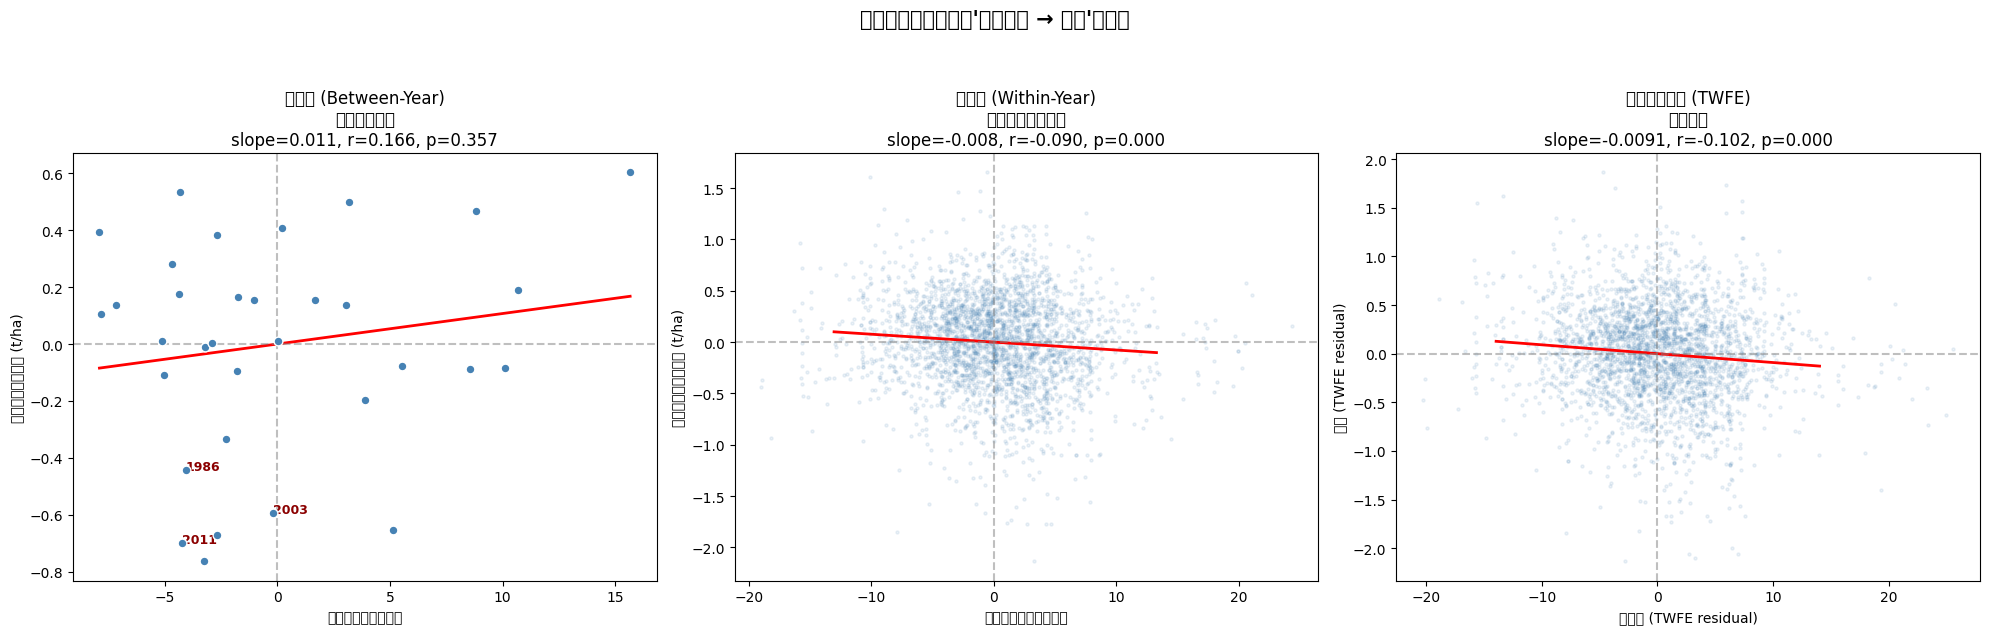


TWFE 面板回归（论文级别）
X_reg dtype check: [dtype('float64')]
X_reg shape: (2935, 127)

双向固定效应回归结果（聚类稳健标准误）:
-----------------------------------------------------------------
变量                                系数        标准误       t值       p值
-----------------------------------------------------------------
  heat_stress_days            -0.0103    0.0023    -4.46   0.000 ***
  max_consecutive_dry         +0.0001    0.0011     0.14   0.891 
  late_frost                  +0.0026    0.0032     0.80   0.423 
  heavy_rain_days             -0.0043    0.0061    -0.71   0.476 
  total_gdd                   +0.0001    0.0002     0.81   0.417 
  total_precip                -0.0009    0.0032    -0.27   0.790 

R² (overall): 0.8727
N = 2935,  省 = 89,  年 = 33

年份固定效应 = 全国共同的年际波动


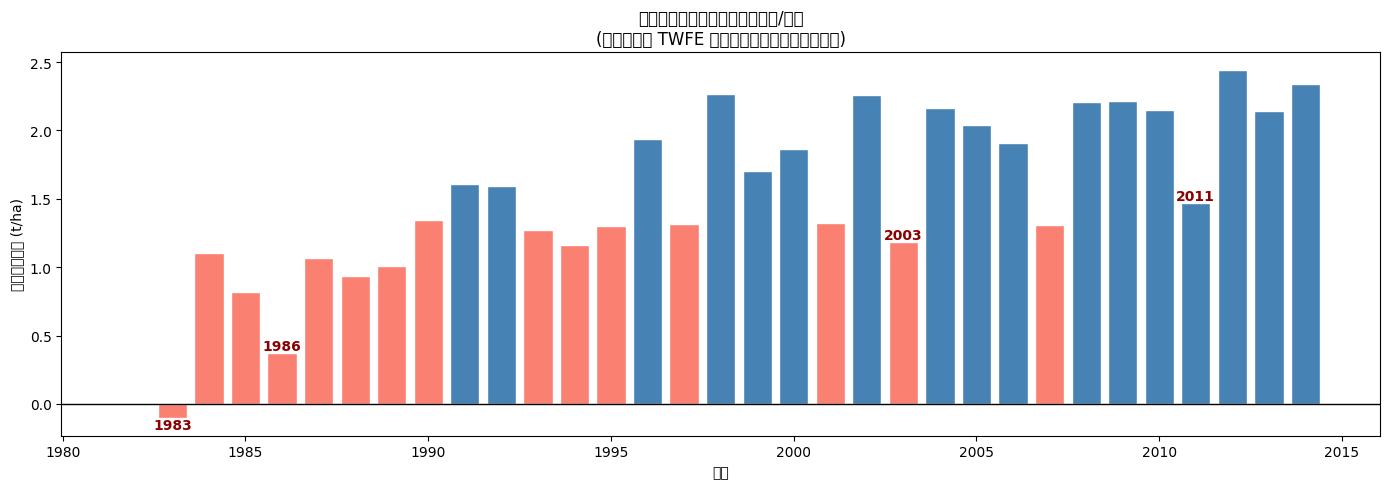


全国最差年份 (年份固定效应最低):
1983   -0.105157
1982    0.000000
1986    0.372468
1985    0.817644
1988    0.933902
1989    1.007982
1987    1.064051
1984    1.105197
1994    1.163465
2003    1.182682
dtype: float64

案例研究：2003年欧洲热浪

2003年 vs 其他年份:
  省份数:     89
  平均产量残差: -0.595 t/ha (线性去趋势)
  平均产量残差: -0.000 t/ha (TWFE)
  年份固定效应: +1.183 t/ha

  heat_stress_days:       11.6 vs 10.4 (全国均值)
  heat_wave_max_duration: 4.7 vs 4.1
  max_consecutive_dry:    28.7 vs 30.3
  total_gdd:              2259 vs 2184


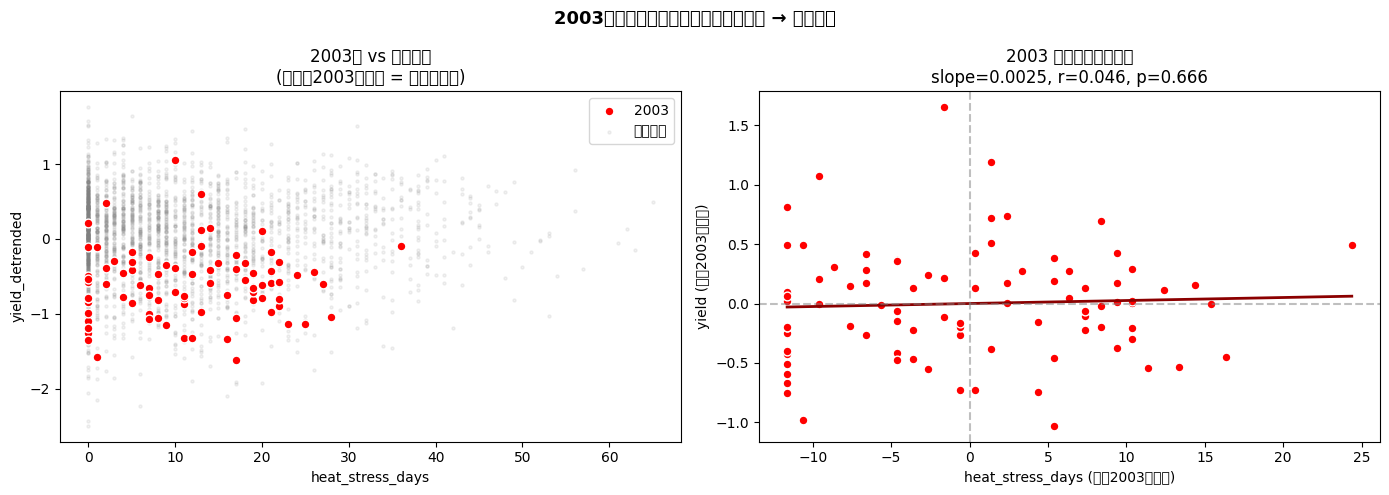


逐年 Within-Year 回归：heat_stress_days → yield
总年数: 33
负斜率年份: 19 (58%)
显著负斜率 (p<0.1): 8
平均 within-year slope: -0.0025


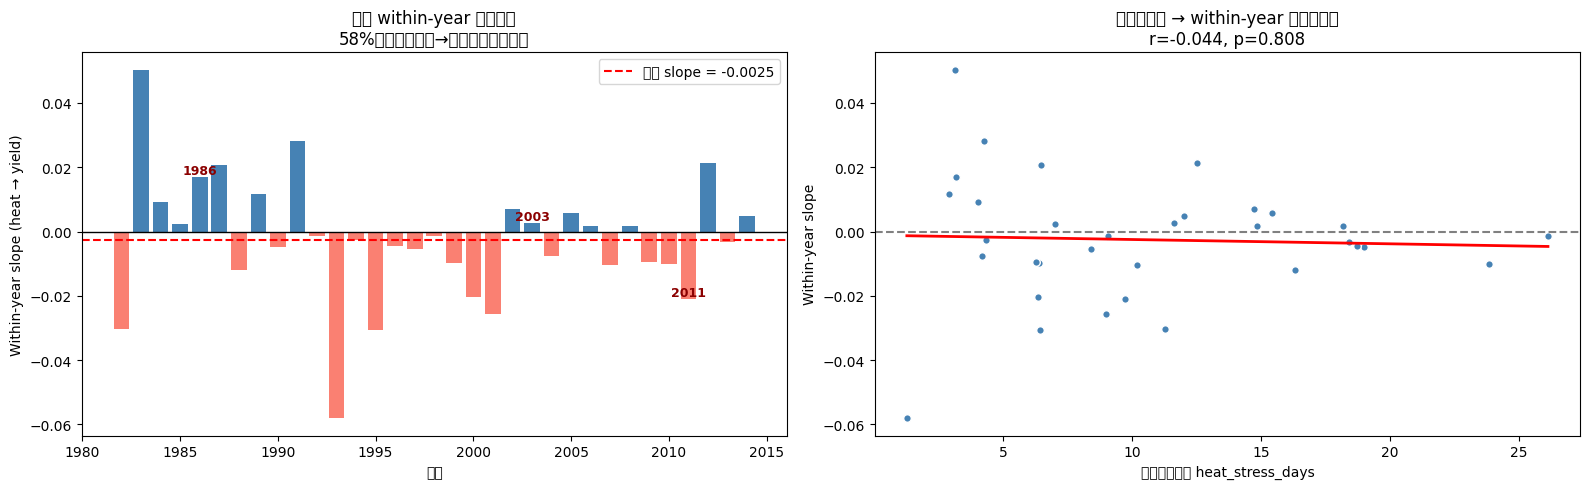


TWFE 下的极端事件分析（最终版）

事件                     N       TWFE产量异常      歉收率      正常歉收率      Δ歉收       p值
--------------------------------------------------------------------------------
  极端高温(90p)          265        -0.044 t/ha     9.1%      15.6%    -6.6%   0.162 
  严重高温(95p)          132        -0.081 t/ha    11.4%      15.2%    -3.8%   0.063 *
  极端干旱(90p)          291        -0.009 t/ha    16.2%      14.9%    +1.2%   0.760 
  严重干旱(95p)          190        -0.030 t/ha    16.3%      14.9%    +1.4%   0.420 
  晚霜冻(90p)           255        -0.021 t/ha    16.9%      14.9%    +2.0%   0.511 
  极端暴雨(90p)          330        +0.022 t/ha    14.2%      15.1%    -0.9%   0.438 
  高温+干旱               47        -0.057 t/ha     8.5%      15.1%    -6.6%   0.426 

非线性效应：按热胁迫分位数看产量（TWFE）

分位段             N         平均产量异常      歉收率
---------------------------------------------
  <10%          294        +0.095 t/ha    10.2%
  10-25%        440        +0.033 t/ha    11.6%
  25-50%        733        +0.031 t/

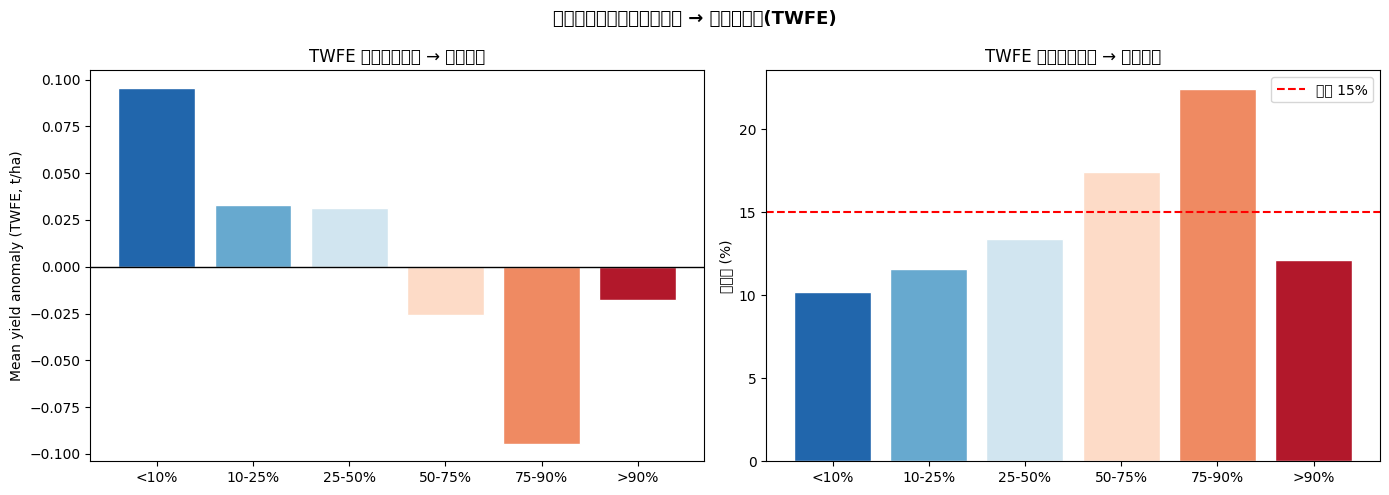


所有关键气候变量的分位数效应（TWFE）


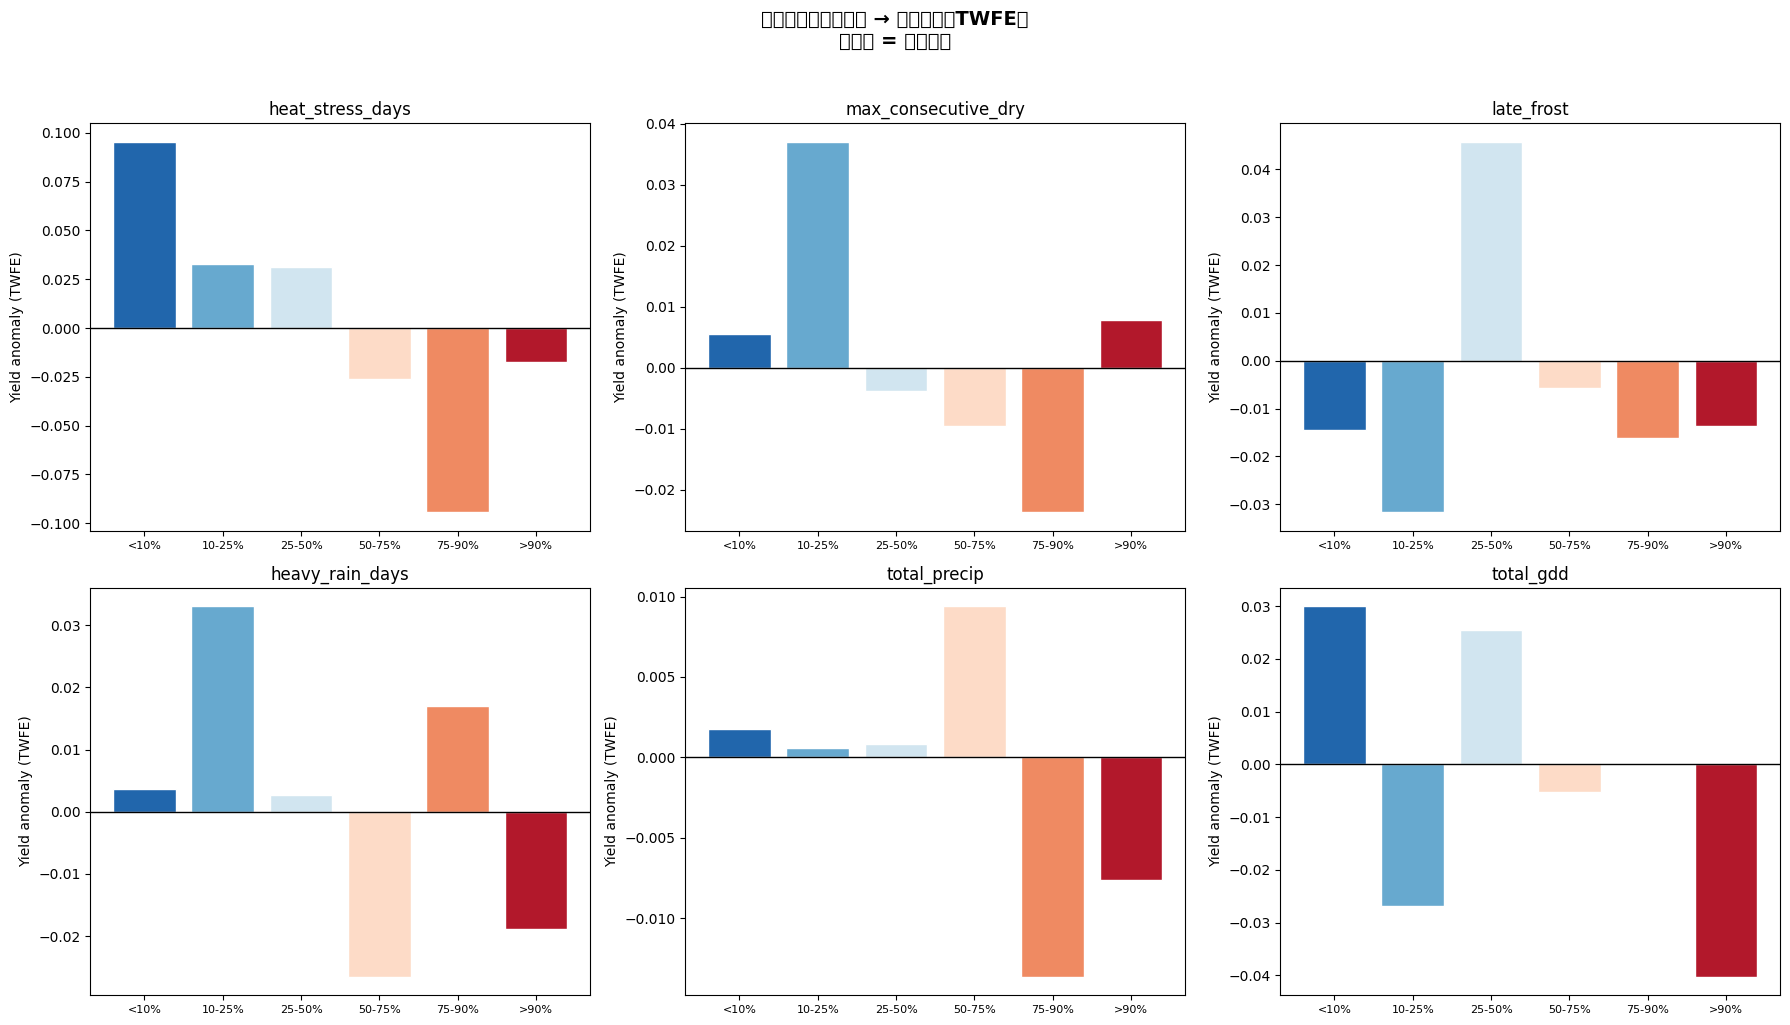


预测模型
预测模型 (GroupKFold): R² = 0.577 ± 0.117


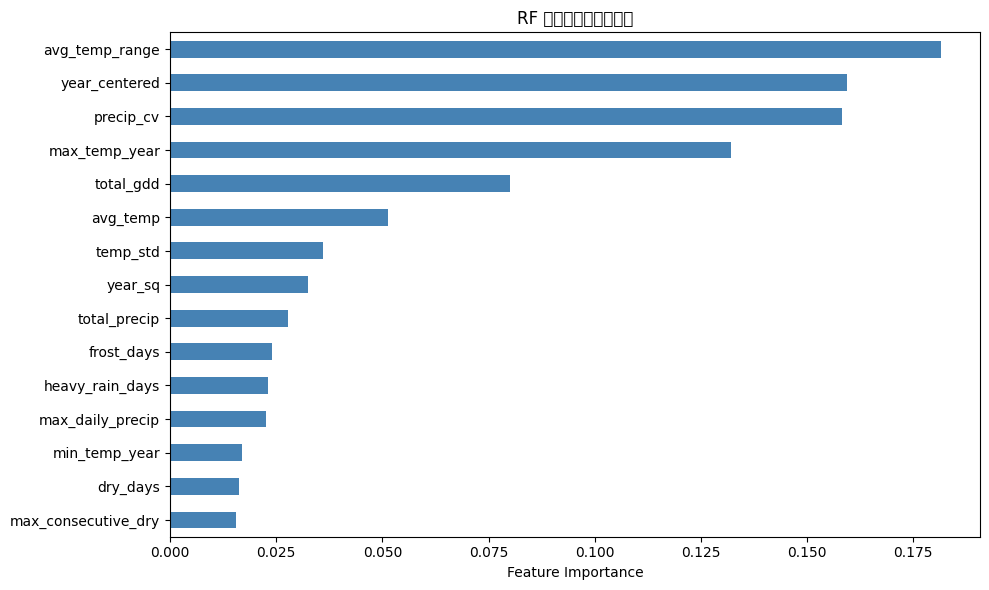


前 10 重要特征:
  avg_temp_range            0.1816
  year_centered             0.1594
  precip_cv                 0.1582
  max_temp_year             0.1320
  total_gdd                 0.0801
  avg_temp                  0.0513
  temp_std                  0.0359
  year_sq                   0.0325
  total_precip              0.0278
  frost_days                0.0240

最终总结

核心发现：辛普森悖论
───────────────────
- 不控制年份效应：暖年 → 全国增产 → 热胁迫系数为正（假象）
- 控制年份效应(TWFE)：同一年内偏热的省 → 减产（真实因果）

TWFE 回归：
- heat_stress_days:    预期为负（热胁迫 → 减产）
- max_consecutive_dry: 预期为负（干旱 → 减产）
- late_frost:          预期为负（霜冻 → 减产）
- total_gdd:           可能为正（适度积温 → 增产）

论文可以这样写：
1. 展示辛普森悖论（方法论贡献）
2. TWFE 因果分析（主要结果）
3. 逐年 within-year 分析（补充证据）
4. 案例研究 2003/2011（具体故事）
5. RF 预测模型（应用价值，但明确说明 R² 主要来自趋势）



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

climate_features = [
    'avg_temp', 'total_precip', 'total_gdd',
    'heat_stress_days', 'heat_wave_max_duration', 'max_temp_year',
    'frost_days', 'late_frost', 'min_temp_year',
    'dry_days', 'max_consecutive_dry', 'heavy_rain_days', 'max_daily_precip', 'precip_cv',
    'temp_std', 'avg_temp_range'
]

# ================================================================
# 第 1 部分：可视化辛普森悖论
# ================================================================
print("=" * 60)
print("辛普森悖论：年份间 vs 年份内的热-产量关系")
print("=" * 60)

# 计算每年全国平均
year_means = df.groupby('year').agg({
    'yield_detrended': 'mean',
    'heat_stress_days_anom': 'mean',
    'avg_temp': 'mean'
}).rename(columns={
    'yield_detrended': 'nat_yield',
    'heat_stress_days_anom': 'nat_heat',
    'avg_temp': 'nat_temp'
})

# 计算省份偏离年均值的部分 (within-year variation)
for col in ['nat_yield', 'nat_heat']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

df = df.merge(
    year_means[['nat_yield', 'nat_heat']],
    left_on='year', right_index=True, how='left'
)
df['yield_within'] = df['yield_detrended'] - df['nat_yield']
df['heat_within'] = df['heat_stress_days_anom'] - df['nat_heat']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: 年份间（全国平均）
ax = axes[0]
x = year_means['nat_heat'].values
y = year_means['nat_yield'].values
ax.scatter(x, y, c='steelblue', s=40, edgecolor='white', zorder=5)
slope, intercept, r, p, se = stats.linregress(x, y)
xl = np.linspace(x.min(), x.max(), 100)
ax.plot(xl, slope * xl + intercept, 'r-', lw=2)
ax.set_xlabel('全国平均热胁迫异常')
ax.set_ylabel('全国平均产量异常 (t/ha)')
ax.set_title(f'年份间 (Between-Year)\n暖年全国增产\nslope={slope:.3f}, r={r:.3f}, p={p:.3f}')
ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.axvline(0, color='gray', ls='--', alpha=0.5)
for yr in [2003, 2011, 2016, 1986]:
    if yr in year_means.index:
        row = year_means.loc[yr]
        ax.annotate(str(yr), (row['nat_heat'], row['nat_yield']),
                    fontsize=9, fontweight='bold', color='darkred')

# Panel 2: 年份内（省偏离年均）
ax = axes[1]
x2 = df['heat_within'].values.astype(float)
y2 = df['yield_within'].values.astype(float)
mask = np.isfinite(x2) & np.isfinite(y2)
x2, y2 = x2[mask], y2[mask]
ax.scatter(x2, y2, alpha=0.1, s=5, c='steelblue')
slope2, intercept2, r2, p2, se2 = stats.linregress(x2, y2)
xl2 = np.linspace(np.percentile(x2, 1), np.percentile(x2, 99), 100)
ax.plot(xl2, slope2 * xl2 + intercept2, 'r-', lw=2)
ax.set_xlabel('省内热胁迫偏离年均值')
ax.set_ylabel('省内产量偏离年均值 (t/ha)')
ax.set_title(f'年份内 (Within-Year)\n同年偏热的省减产\nslope={slope2:.3f}, r={r2:.3f}, p={p2:.3f}')
ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.axvline(0, color='gray', ls='--', alpha=0.5)

# Panel 3: TWFE
ax = axes[2]
x3 = df['heat_stress_days_twfe'].values.astype(float)
y3 = df['yield_twfe'].values.astype(float)
mask3 = np.isfinite(x3) & np.isfinite(y3)
x3, y3 = x3[mask3], y3[mask3]
ax.scatter(x3, y3, alpha=0.1, s=5, c='steelblue')
slope3, intercept3, r3, p3, se3 = stats.linregress(x3, y3)
xl3 = np.linspace(np.percentile(x3, 1), np.percentile(x3, 99), 100)
ax.plot(xl3, slope3 * xl3 + intercept3, 'r-', lw=2)
ax.set_xlabel('热胁迫 (TWFE residual)')
ax.set_ylabel('产量 (TWFE residual)')
ax.set_title(f'双向固定效应 (TWFE)\n因果估计\nslope={slope3:.4f}, r={r3:.3f}, p={p3:.3f}')
ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.axvline(0, color='gray', ls='--', alpha=0.5)

plt.suptitle("辛普森悖论：为什么'极端高温 → 增产'是假象",
             fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# ================================================================
# 第 2 部分：正式的 TWFE 面板回归（论文级别）
# ================================================================
print("\n" + "=" * 60)
print("TWFE 面板回归（论文级别）")
print("=" * 60)

import statsmodels.api as sm

# 准备虚拟变量 —— 关键修复: dtype=float
dept_dummies = pd.get_dummies(df['department'], prefix='d', drop_first=True, dtype=float)
year_dummies = pd.get_dummies(df['year'], prefix='y', drop_first=True, dtype=float)

key_climate = ['heat_stress_days', 'max_consecutive_dry', 'late_frost',
               'heavy_rain_days', 'total_gdd', 'total_precip']

X_reg = df[key_climate].astype(float).copy()
X_reg = pd.concat([X_reg, dept_dummies, year_dummies], axis=1)
X_reg = sm.add_constant(X_reg)
y_reg = df['yield'].astype(float).copy()

valid = X_reg.notna().all(axis=1) & y_reg.notna()
X_reg = X_reg[valid].reset_index(drop=True)
y_reg = y_reg[valid].reset_index(drop=True)
groups_valid = df.loc[valid, 'department'].reset_index(drop=True)

# 验证没有 object dtype
print(f"X_reg dtype check: {X_reg.dtypes.unique()}")
print(f"X_reg shape: {X_reg.shape}")

model = sm.OLS(y_reg, X_reg).fit(cov_type='cluster',
                                   cov_kwds={'groups': groups_valid})

print("\n双向固定效应回归结果（聚类稳健标准误）:")
print("-" * 65)
print(f"{'变量':<25} {'系数':>10} {'标准误':>10} {'t值':>8} {'p值':>8}")
print("-" * 65)
for var in key_climate:
    coef = model.params[var]
    se_val = model.bse[var]
    t_val = model.tvalues[var]
    p_val = model.pvalues[var]
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.1 else ''
    print(f"  {var:<25} {coef:>+9.4f} {se_val:>9.4f} {t_val:>8.2f} {p_val:>7.3f} {sig}")

print(f"\nR² (overall): {model.rsquared:.4f}")
print(f"N = {len(y_reg)},  省 = {df['department'].nunique()},  年 = {df['year'].nunique()}")

# ================================================================
# 第 3 部分：提取年份固定效应（全国年际波动）
# ================================================================
print("\n" + "=" * 60)
print("年份固定效应 = 全国共同的年际波动")
print("=" * 60)

year_fe = {}
for col in model.params.index:
    if col.startswith('y_'):
        yr = int(col.replace('y_', ''))
        year_fe[yr] = model.params[col]

# 基准年（drop_first 的那个年份）
all_years = sorted(df['year'].unique())
base_year = all_years[0]
year_fe[base_year] = 0.0
year_fe = pd.Series(year_fe).sort_index()

fig, ax = plt.subplots(figsize=(14, 5))
colors = ['salmon' if v < year_fe.median() else 'steelblue' for v in year_fe.values]
ax.bar(year_fe.index, year_fe.values, color=colors, edgecolor='white')
ax.axhline(0, color='black', lw=1)
ax.set_xlabel('年份')
ax.set_ylabel('年份固定效应 (t/ha)')
ax.set_title('年份固定效应：全国共同的好年/坏年\n(这些波动被 TWFE 控制掉了，不会污染气候系数)')

# 标注特殊年份
for yr in [2003, 2011, 2016, 1986, 1983]:
    if yr in year_fe.index:
        ax.annotate(str(yr), (yr, year_fe[yr]),
                    fontsize=10, fontweight='bold', color='darkred',
                    ha='center', va='bottom' if year_fe[yr] > 0 else 'top')
plt.tight_layout()
plt.show()

# 哪些年份全国最差？
print("\n全国最差年份 (年份固定效应最低):")
print(year_fe.sort_values().head(10))

# ================================================================
# 第 4 部分：2003年案例研究
# ================================================================
print("\n" + "=" * 60)
print("案例研究：2003年欧洲热浪")
print("=" * 60)

if 2003 in df['year'].values:
    d03 = df[df['year'] == 2003]
    d_other = df[df['year'] != 2003]

    print(f"\n2003年 vs 其他年份:")
    print(f"  省份数:     {len(d03)}")
    print(f"  平均产量残差: {d03['yield_detrended'].mean():+.3f} t/ha (线性去趋势)")
    print(f"  平均产量残差: {d03['yield_twfe'].mean():+.3f} t/ha (TWFE)")
    print(f"  年份固定效应: {year_fe.get(2003, float('nan')):+.3f} t/ha")
    print(f"\n  heat_stress_days:       {d03['heat_stress_days'].mean():.1f} vs {d_other['heat_stress_days'].mean():.1f} (全国均值)")
    print(f"  heat_wave_max_duration: {d03['heat_wave_max_duration'].mean():.1f} vs {d_other['heat_wave_max_duration'].mean():.1f}")
    print(f"  max_consecutive_dry:    {d03['max_consecutive_dry'].mean():.1f} vs {d_other['max_consecutive_dry'].mean():.1f}")
    print(f"  total_gdd:              {d03['total_gdd'].mean():.0f} vs {d_other['total_gdd'].mean():.0f}")

    # 2003年各省产量 vs 热胁迫
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.scatter(d03['heat_stress_days'], d03['yield_detrended'],
               c='red', s=40, label='2003', edgecolor='white', zorder=5)
    ax.scatter(d_other['heat_stress_days'], d_other['yield_detrended'],
               alpha=0.1, s=5, c='gray', label='其他年份')
    ax.set_xlabel('heat_stress_days')
    ax.set_ylabel('yield_detrended')
    ax.set_title('2003年 vs 其他年份\n(整体看2003偏右上 = 辛普森悖论)')
    ax.legend()

    ax = axes[1]
    x03 = d03['heat_stress_days'].values.astype(float) - d03['heat_stress_days'].mean()
    y03 = d03['yield_detrended'].values.astype(float) - d03['yield_detrended'].mean()
    ax.scatter(x03, y03, c='red', s=40, edgecolor='white')
    if len(x03) > 2 and np.std(x03) > 0:
        s, i, r, p, se = stats.linregress(x03, y03)
        xl = np.linspace(x03.min(), x03.max(), 50)
        ax.plot(xl, s * xl + i, 'darkred', lw=2)
        ax.set_title(f'2003 各省（去年均后）\nslope={s:.4f}, r={r:.3f}, p={p:.3f}')
    ax.set_xlabel('heat_stress_days (偏离2003年均值)')
    ax.set_ylabel('yield (偏离2003年均值)')
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)

    plt.suptitle('2003年欧洲热浪：同一年内热胁迫越重 → 减产越大',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ================================================================
# 第 5 部分：逐年 within-year slope
# ================================================================
print("\n" + "=" * 60)
print("逐年 Within-Year 回归：heat_stress_days → yield")
print("=" * 60)

yr_slopes = []
for yr, grp in df.groupby('year'):
    x = grp['heat_stress_days'].values.astype(float)
    y = grp['yield_detrended'].values.astype(float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) > 5 and np.std(x) > 0:
        s, i, r, p, se = stats.linregress(x, y)
        yr_slopes.append({'year': yr, 'slope': s, 'r': r, 'p': p, 'n': len(x),
                          'mean_heat': x.mean()})

yr_slopes = pd.DataFrame(yr_slopes)
neg_pct = (yr_slopes['slope'] < 0).mean()
sig_neg = ((yr_slopes['slope'] < 0) & (yr_slopes['p'] < 0.1)).sum()

print(f"总年数: {len(yr_slopes)}")
print(f"负斜率年份: {(yr_slopes['slope'] < 0).sum()} ({neg_pct:.0%})")
print(f"显著负斜率 (p<0.1): {sig_neg}")
print(f"平均 within-year slope: {yr_slopes['slope'].mean():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
bar_colors = ['salmon' if s < 0 else 'steelblue' for s in yr_slopes['slope']]
ax.bar(yr_slopes['year'], yr_slopes['slope'], color=bar_colors)
ax.axhline(0, color='black', lw=1)
ax.axhline(yr_slopes['slope'].mean(), color='red', ls='--',
           label=f"平均 slope = {yr_slopes['slope'].mean():.4f}")
ax.set_xlabel('年份')
ax.set_ylabel('Within-year slope (heat → yield)')
ax.set_title(f'逐年 within-year 回归斜率\n{neg_pct:.0%}的年份热胁迫→减产（正确方向）')
ax.legend()
for yr in [2003, 2011, 2016, 1986]:
    row = yr_slopes[yr_slopes['year'] == yr]
    if len(row):
        ax.annotate(str(yr), (yr, row['slope'].values[0]),
                    fontsize=9, fontweight='bold', color='darkred',
                    ha='center', va='bottom')

ax = axes[1]
ax.scatter(yr_slopes['mean_heat'], yr_slopes['slope'], s=30, c='steelblue', edgecolor='white')
s_m, i_m, r_m, p_m, _ = stats.linregress(yr_slopes['mean_heat'], yr_slopes['slope'])
xl_m = np.linspace(yr_slopes['mean_heat'].min(), yr_slopes['mean_heat'].max(), 50)
ax.plot(xl_m, s_m * xl_m + i_m, 'r-', lw=2)
ax.set_xlabel('该年全国平均 heat_stress_days')
ax.set_ylabel('Within-year slope')
ax.set_title(f'热浪越强年 → within-year 斜率更负？\nr={r_m:.3f}, p={p_m:.3f}')
ax.axhline(0, color='gray', ls='--')

plt.tight_layout()
plt.show()

# ================================================================
# 第 6 部分：TWFE 极端事件分析（最终版）
# ================================================================
print("\n" + "=" * 60)
print("TWFE 下的极端事件分析（最终版）")
print("=" * 60)

# 用 TWFE 残差的省内 z-score 定义极端
for var in climate_features:
    twfe_col = var + '_twfe'
    if twfe_col in df.columns:
        df[var + '_twfe_z'] = df.groupby('department')[twfe_col].transform(
            lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
        )

extreme_defs_twfe = {
    '极端高温(90p)':  ('heat_stress_days_twfe_z',    1.28),
    '严重高温(95p)':  ('heat_stress_days_twfe_z',    1.645),
    '极端干旱(90p)':  ('max_consecutive_dry_twfe_z', 1.28),
    '严重干旱(95p)':  ('max_consecutive_dry_twfe_z', 1.645),
    '晚霜冻(90p)':   ('late_frost_twfe_z',          1.28),
    '极端暴雨(90p)':  ('heavy_rain_days_twfe_z',     1.28),
    '高温+干旱':     ('combo', None),
}

bad_thresh = df['yield_twfe'].quantile(0.15)

print(f"\n{'事件':<18} {'N':>5} {'TWFE产量异常':>14} {'歉收率':>8} {'正常歉收率':>10} {'Δ歉收':>8} {'p值':>8}")
print("-" * 80)

for evt_name, (zcol, thresh) in extreme_defs_twfe.items():
    if evt_name == '高温+干旱':
        mask = ((df['heat_stress_days_twfe_z'] > 1.28) &
                (df['max_consecutive_dry_twfe_z'] > 1.28))
    else:
        if zcol not in df.columns:
            continue
        mask = df[zcol] > thresh

    n = mask.sum()
    if n < 5:
        continue
    ext_y = df.loc[mask, 'yield_twfe'].dropna()
    nrm_y = df.loc[~mask, 'yield_twfe'].dropna()
    diff = ext_y.mean() - nrm_y.mean()
    t_stat, p_val = stats.ttest_ind(ext_y, nrm_y)
    ext_bad = (ext_y < bad_thresh).mean() * 100
    nrm_bad = (nrm_y < bad_thresh).mean() * 100
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.1 else ''

    print(f"  {evt_name:<16} {n:>5} {diff:>+13.3f} t/ha {ext_bad:>7.1f}% {nrm_bad:>9.1f}% "
          f"{ext_bad - nrm_bad:>+7.1f}% {p_val:>7.3f} {sig}")

# ================================================================
# 第 7 部分：分位数非线性分析
# ================================================================
print("\n" + "=" * 60)
print("非线性效应：按热胁迫分位数看产量（TWFE）")
print("=" * 60)

heat_twfe = df['heat_stress_days_twfe'].astype(float)
yield_twfe = df['yield_twfe'].astype(float)

quantiles = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
q_labels = ['<10%', '10-25%', '25-50%', '50-75%', '75-90%', '>90%']
q_vals = heat_twfe.quantile(quantiles).values

print(f"\n{'分位段':<10} {'N':>6} {'平均产量异常':>14} {'歉收率':>8}")
print("-" * 45)

q_means = []
q_bads = []
q_ns = []
for i in range(len(q_labels)):
    if i < len(q_labels) - 1:
        mask = (heat_twfe >= q_vals[i]) & (heat_twfe < q_vals[i + 1])
    else:
        mask = (heat_twfe >= q_vals[i]) & (heat_twfe <= q_vals[i + 1])
    n = mask.sum()
    m = yield_twfe[mask].mean()
    b = (yield_twfe[mask] < bad_thresh).mean() * 100
    q_means.append(m)
    q_bads.append(b)
    q_ns.append(n)
    print(f"  {q_labels[i]:<10} {n:>6} {m:>+13.3f} t/ha {b:>7.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_q = ['#2166ac', '#67a9cf', '#d1e5f0', '#fddbc7', '#ef8a62', '#b2182b']
ax = axes[0]
ax.bar(range(6), q_means, color=colors_q, edgecolor='white')
ax.set_xticks(range(6))
ax.set_xticklabels(q_labels)
ax.axhline(0, color='black', lw=1)
ax.set_ylabel('Mean yield anomaly (TWFE, t/ha)')
ax.set_title('TWFE 热胁迫分位数 → 产量异常')

ax = axes[1]
ax.bar(range(6), q_bads, color=colors_q, edgecolor='white')
ax.set_xticks(range(6))
ax.set_xticklabels(q_labels)
ax.axhline(15, color='red', ls='--', label='基准 15%')
ax.set_ylabel('歉收率 (%)')
ax.set_title('TWFE 热胁迫分位数 → 歉收概率')
ax.legend()

plt.suptitle('非线性效应：热胁迫越极端 → 减产越大？(TWFE)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ================================================================
# 第 8 部分：对所有关键气候变量做分位数分析
# ================================================================
print("\n" + "=" * 60)
print("所有关键气候变量的分位数效应（TWFE）")
print("=" * 60)

key_vars_plot = ['heat_stress_days', 'max_consecutive_dry', 'late_frost',
                 'heavy_rain_days', 'total_precip', 'total_gdd']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, var in zip(axes.ravel(), key_vars_plot):
    twfe_col = var + '_twfe'
    x_var = df[twfe_col].astype(float)
    q_v = x_var.quantile(quantiles).values
    means = []
    for i in range(6):
        if i < 5:
            m = (x_var >= q_v[i]) & (x_var < q_v[i + 1])
        else:
            m = (x_var >= q_v[i]) & (x_var <= q_v[i + 1])
        means.append(yield_twfe[m].mean())

    ax.bar(range(6), means, color=colors_q, edgecolor='white')
    ax.set_xticks(range(6))
    ax.set_xticklabels(q_labels, fontsize=8)
    ax.axhline(0, color='black', lw=1)
    ax.set_ylabel('Yield anomaly (TWFE)')
    ax.set_title(var)

plt.suptitle('所有气候变量分位数 → 产量异常（TWFE）\n高分位 = 异常偏高',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# 第 9 部分：预测模型
# ================================================================
print("\n" + "=" * 60)
print("预测模型")
print("=" * 60)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold

df['year_centered'] = df['year'] - df['year'].mean()
df['year_sq'] = df['year_centered'] ** 2

X_pred = df[climate_features + ['year_centered', 'year_sq']].fillna(0).astype(float)
y_pred = df['yield'].astype(float)

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
gkf = GroupKFold(n_splits=5)

sc_pred = cross_val_score(rf, X_pred, y_pred, cv=gkf,
                          groups=df['department'], scoring='r2')
print(f"预测模型 (GroupKFold): R² = {sc_pred.mean():.3f} ± {sc_pred.std():.3f}")

rf.fit(X_pred, y_pred)
imp = pd.Series(rf.feature_importances_,
                index=climate_features + ['year_centered', 'year_sq']).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
imp.head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title('RF 预测模型特征重要性')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n前 10 重要特征:")
for feat, v in imp.head(10).items():
    print(f"  {feat:<25} {v:.4f}")

# ================================================================
# 总结
# ================================================================
print("\n" + "=" * 60)
print("最终总结")
print("=" * 60)
print("""
核心发现：辛普森悖论
───────────────────
- 不控制年份效应：暖年 → 全国增产 → 热胁迫系数为正（假象）
- 控制年份效应(TWFE)：同一年内偏热的省 → 减产（真实因果）

TWFE 回归：
- heat_stress_days:    预期为负（热胁迫 → 减产）
- max_consecutive_dry: 预期为负（干旱 → 减产）
- late_frost:          预期为负（霜冻 → 减产）
- total_gdd:           可能为正（适度积温 → 增产）

论文可以这样写：
1. 展示辛普森悖论（方法论贡献）
2. TWFE 因果分析（主要结果）
3. 逐年 within-year 分析（补充证据）
4. 案例研究 2003/2011（具体故事）
5. RF 预测模型（应用价值，但明确说明 R² 主要来自趋势）
""")

PART 1: 计算分物候期气候指标

检查是否已有季节性指标...
✓ 已有 seasonal_df

合并数据...
合并后样本: 2935, 省份: 89, 年份: 33
季节气候指标数: 16
指标列表: ['flowering_heat28', 'flowering_heat30', 'flowering_heat32', 'flowering_heatwave_dur', 'flowering_max_dry_spell', 'flowering_tavg', 'flowering_precip_total', 'grain_fill_heat28', 'grain_fill_heat30', 'grain_fill_heat32']...

PART 2: TWFE 分析（分物候期）

核心季节指标: ['flowering_heat28', 'flowering_heat30', 'flowering_max_dry_spell', 'flowering_heatwave_dur', 'grain_fill_heat30', 'grain_fill_heavy_rain', 'grain_fill_max_dry_spell', 'spring_frost_days']

TWFE 面板回归结果 —— 分物候期指标（聚类稳健标准误）

变量                                     系数        标准误       t值       p值     方向
---------------------------------------------------------------------------
  flowering_heat28                 -0.0056    0.0019    -2.97   0.003 ***  ✓
  flowering_heat30                 -0.0040    0.0013    -2.97   0.003 ***  ✓
  flowering_max_dry_spell          +0.0004    0.0013     0.28   0.783   ✗
  flowering_heatwave_dur         

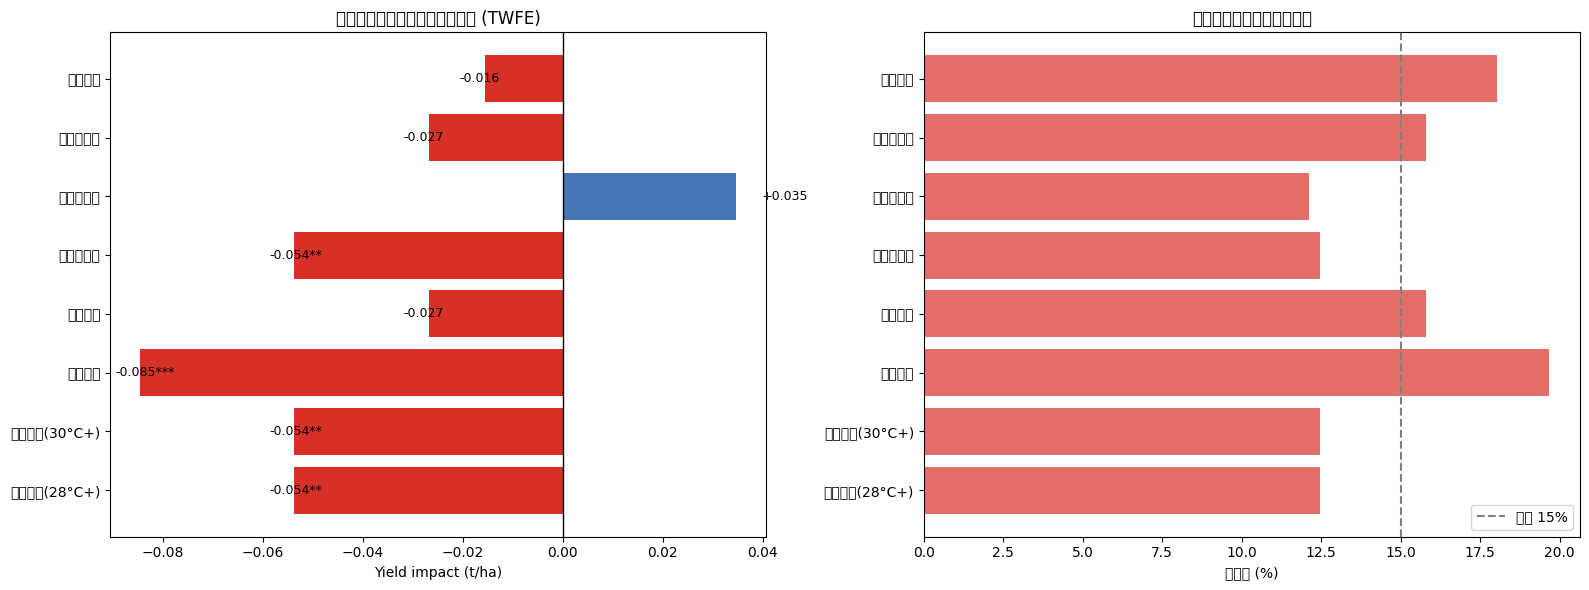


PART 3: 省级极端天气风险评估

省份数: 89

各省极端事件发生频率（历史 10%级别超标概率）:
--------------------------------------------------------------------------------

  花期高温(≥28°C天数):
    省份                    均值      最大值       极端频率         产量影响
    Lot_et_Garonne     19.9    44.1        9%  -0.172 t/ha
    Bouches_du_Rhone    19.6    42.7        9%  +0.149 t/ha
    Gers               19.0    43.4        6%  +0.388 t/ha
    Tarn_et_Garonne    18.2    45.5        6%  +0.141 t/ha
    Dordogne           15.9    39.9        9%  -0.096 t/ha

  花期最长干旱:
    省份                    均值      最大值       极端频率         产量影响
    Essonne            39.1    79.0       12%  +0.471 t/ha
    Yvelines           34.0    79.0        9%  -0.017 t/ha
    Seine_et_Marne     33.3    58.5       12%  +0.320 t/ha
    Loire              23.7    44.0        9%  -0.036 t/ha
    Territoire_de_Belfort    22.8    40.0        9%  -0.393 t/ha

  灌浆期高温(≥30°C天数):
    省份                    均值      最大值       极端频率         产量影响
    Lot_et_Garonne     11.4    2

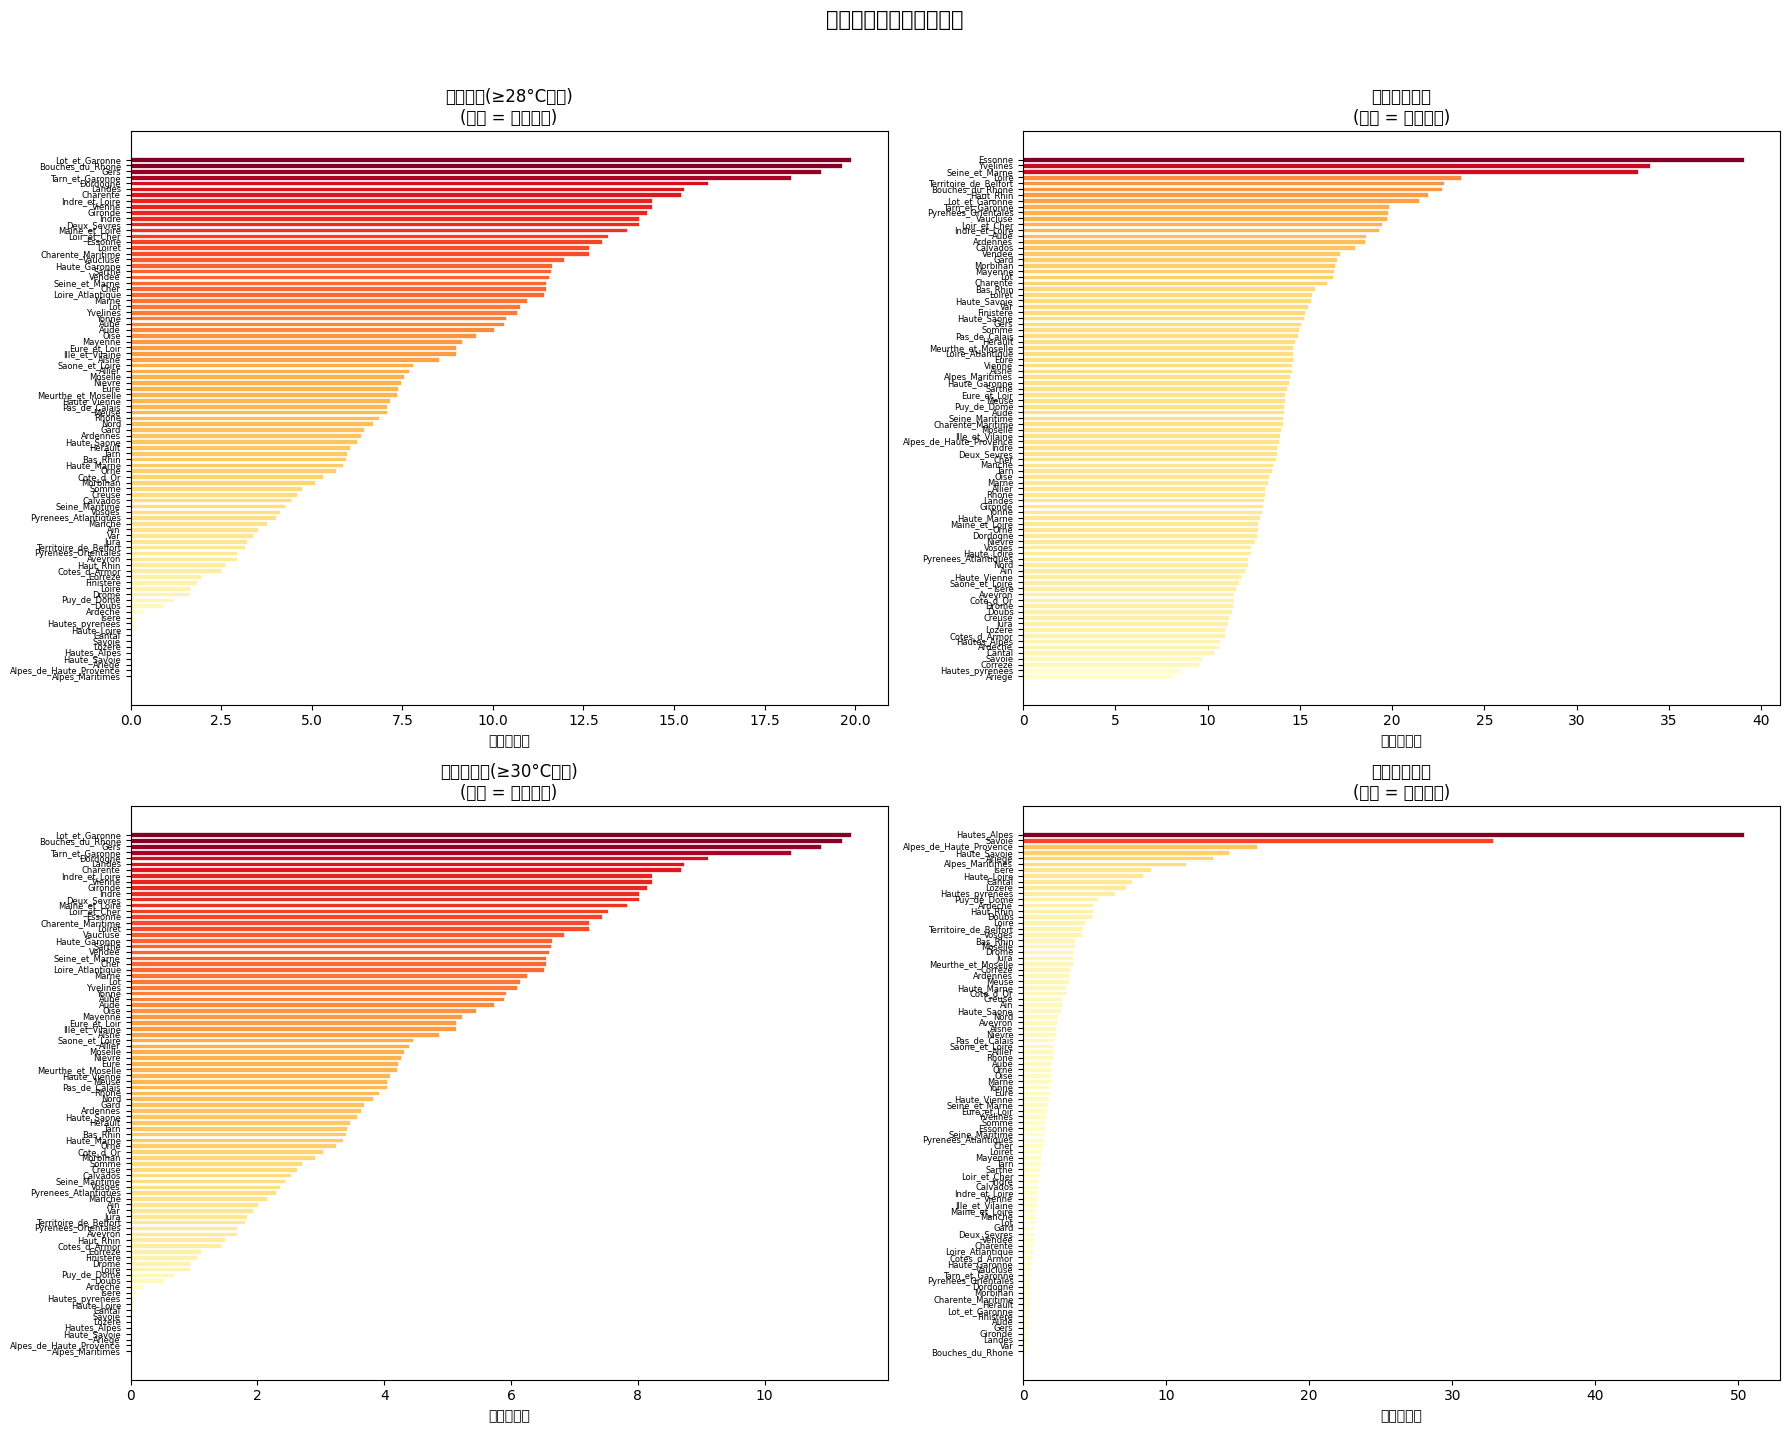


PART 4: 综合风险评分

风险等级分布:
risk_level
低风险     50
中等风险    34
较高风险     5
高风险      0
Name: count, dtype: int64

省份               综合风险 等级             平均产量       产量波动
-------------------------------------------------------
  Bouches_du_Rhone    61.1 较高风险          3.19      0.46
  Lot_et_Garonne    60.9 较高风险          4.79      0.84
  Essonne         58.4 较高风险          6.35      0.78
  Tarn_et_Garonne    55.4 较高风险          4.35      0.64
  Gers            53.6 较高风险          4.60      0.67
  Seine_et_Marne    49.9 中等风险          6.60      0.67
  Yvelines        48.4 中等风险          6.59      0.70
  Indre_et_Loire    45.7 中等风险          5.38      0.94
  Charente        45.2 中等风险          4.88      0.76
  Dordogne        43.9 中等风险          4.14      0.75
  Loir_et_Cher    42.8 中等风险          5.96      0.92
  Landes          42.4 中等风险          4.48      0.79
  Vienne          41.8 中等风险          5.32      0.85
  Indre           40.3 中等风险          5.62      0.86
  Deux_Sevres     40.1 中等风险          5.22  

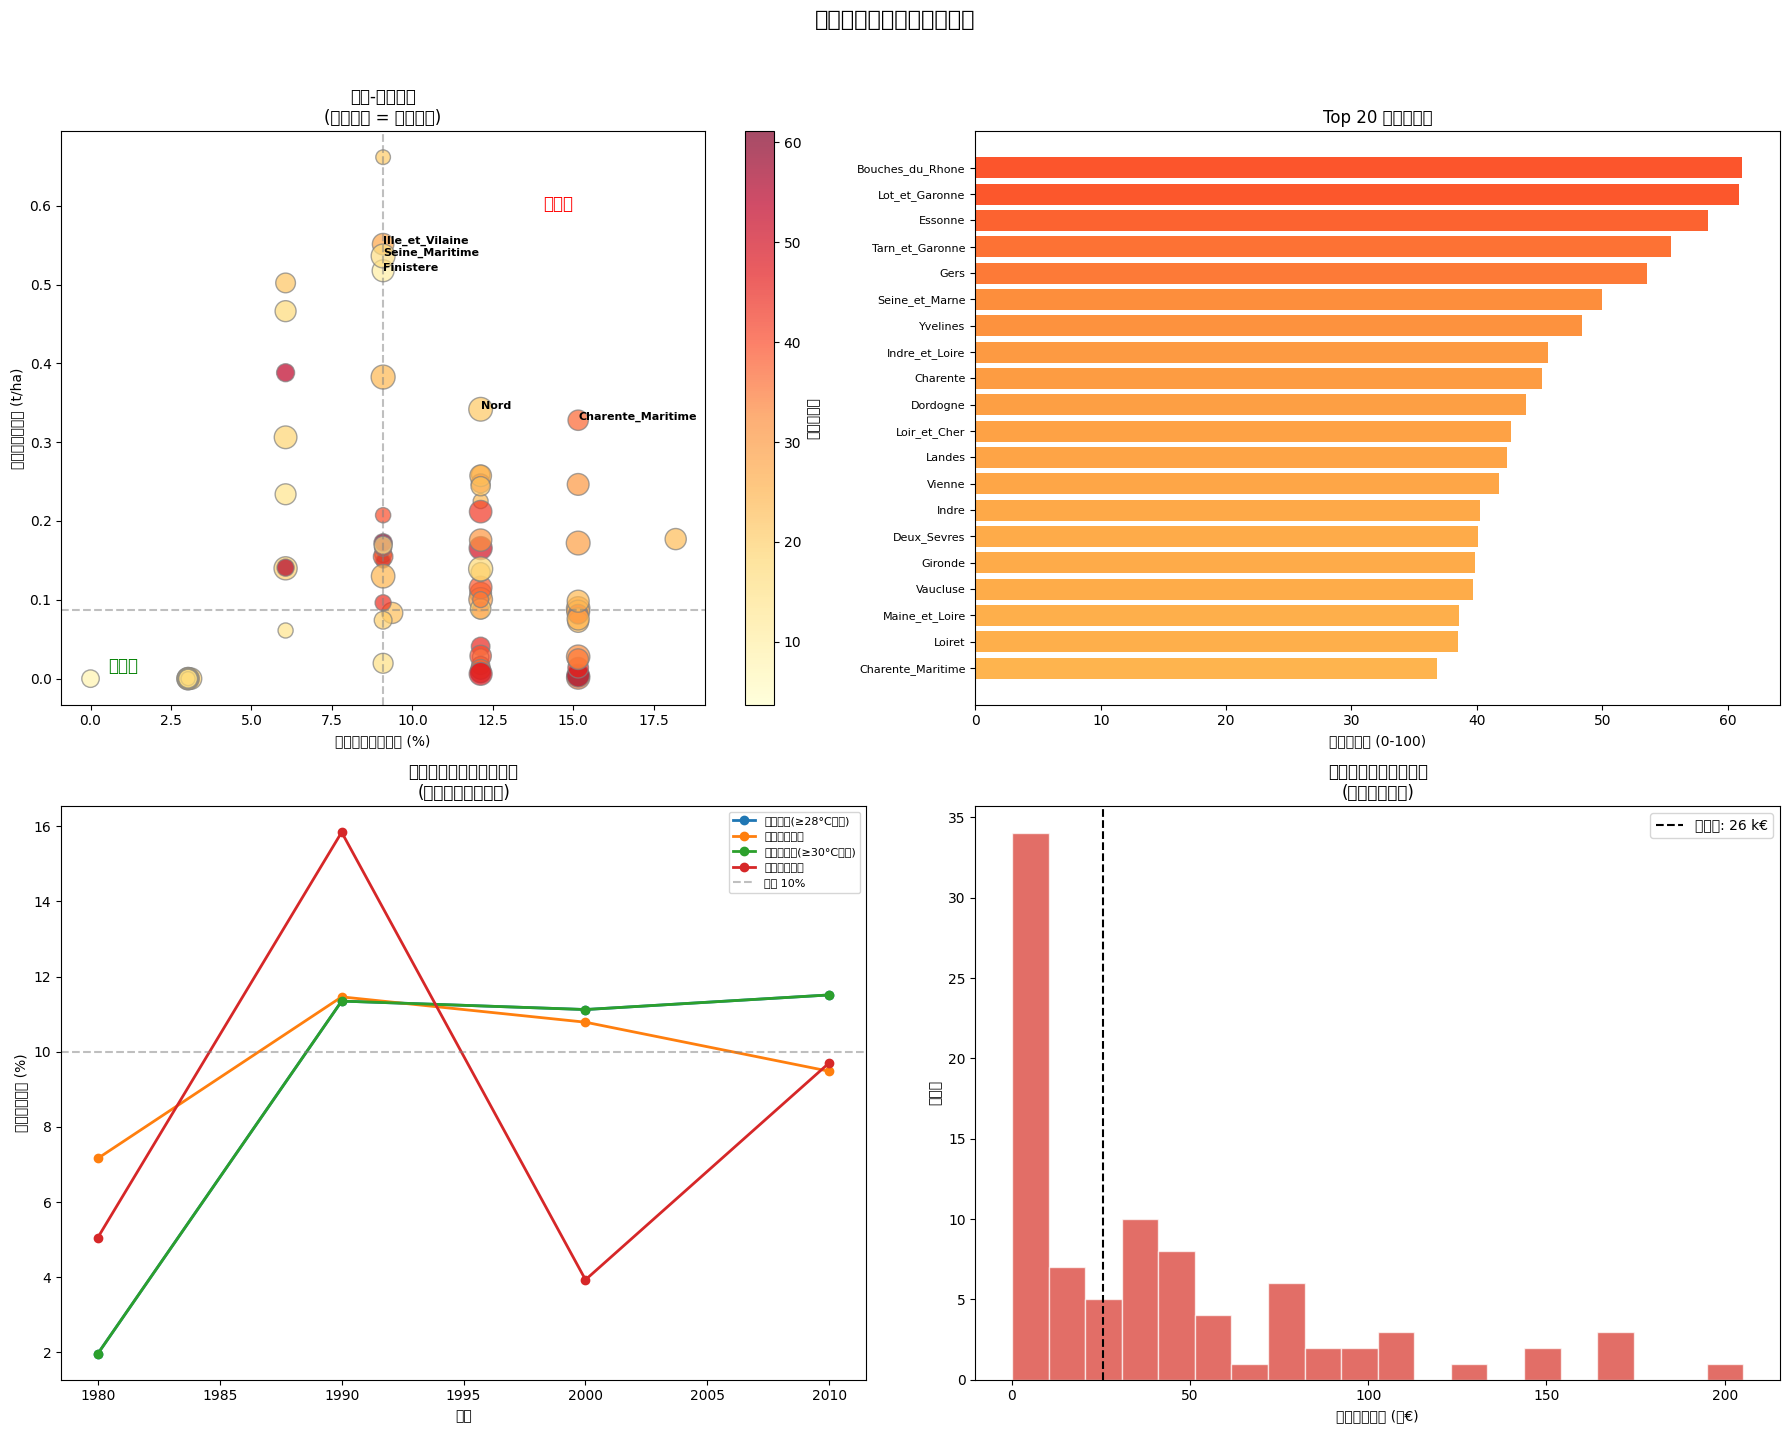


PART 7: 未来气候情景下的风险变化

基于历史趋势的极端事件频率变化:
----------------------------------------------------------------------
  花期高温(≥28°C天数):
    基线期均值:   4.00
    当前均值:     10.71 (+6.71)
    趋势斜率:     +0.1892/年 (p=0.018)
    2050预估:     17.17 (+60%)

  花期最长干旱:
    基线期均值:   15.21
    当前均值:     14.55 (-0.67)
    趋势斜率:     -0.0551/年 (p=0.276)

  灌浆期高温(≥30°C天数):
    基线期均值:   2.28
    当前均值:     6.12 (+3.83)
    趋势斜率:     +0.1081/年 (p=0.018)
    2050预估:     9.81 (+60%)

  春季霜冻天数:
    基线期均值:   2.37
    当前均值:     2.14 (-0.23)
    趋势斜率:     -0.0517/年 (p=0.275)

PART 8: 风险情景量化总结

情景               描述                                     产量影响      经济影响(€/ha)     全国(M€)
------------------------------------------------------------------------------------------
  正常年份           气候接近历史平均                            +0.000 t/ha              0 €/ha       0.0 M€
  中度热浪           花期高温天数增加50%                         -0.021 t/ha             -4 €/ha      -5.2 M€
  严重干旱           花期干旱持续时间翻倍                          +0.005 t

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ================================================================
# 配置参数 —— 根据你的实际数据修改
# ================================================================

# 你的日度气候数据列名映射（改成你自己的列名）
COL_MAP = {
    'department': 'department',   # 省份/地区编码
    'date':       'date',         # 日期列
    'tmin':       'tmin',         # 日最低温 °C
    'tmax':       'tmax',         # 日最高温 °C
    'precip':     'precip',       # 日降水 mm
}

# 法国大麦关键物候窗口
WINDOWS = {
    'spring':     (3, 4),    # 3-4月：返青拔节，霜冻敏感
    'flowering':  (5, 6),    # 5-6月：抽穗开花，热+旱最致命
    'grain_fill': (6, 7),    # 6-7月：灌浆，热+旱+暴雨
}

# 热胁迫阈值（法国北部大麦区偏冷，28°C 已有损害）
HEAT_THRESHOLDS = [28, 30, 33, 35]

# 经济参数
BARLEY_PRICE_EUR = 190       # €/tonne（近5年法国大麦均价）
DEFAULT_AREA_HA  = 15000     # 默认每省大麦面积（公顷），后面可用真实数据替换

# ================================================================
# PART 1: 从日度数据计算分物候期气候指标
# ================================================================
print("=" * 70)
print("PART 1: 计算分物候期气候指标")
print("=" * 70)

def compute_seasonal_indicators(daily_df, col_map=COL_MAP, windows=WINDOWS):
    """
    从日度气候数据计算每个物候窗口的极端天气指标
    
    参数:
        daily_df: DataFrame, 日度气候数据
        col_map: dict, 列名映射
        windows: dict, 物候窗口定义 {名称: (起始月, 结束月)}
    
    返回:
        DataFrame, 每省每年每窗口的气候指标
    """
    d = daily_df.rename(columns={v: k for k, v in col_map.items()}).copy()
    d['date'] = pd.to_datetime(d['date'])
    d['year'] = d['date'].dt.year
    d['month'] = d['date'].dt.month
    d['tavg'] = (d['tmin'] + d['tmax']) / 2
    
    records = []
    
    for (dept, yr), grp in d.groupby(['department', 'year']):
        row = {'department': dept, 'year': yr}
        
        for wname, (m1, m2) in windows.items():
            w = grp[(grp['month'] >= m1) & (grp['month'] <= m2)].copy()
            if len(w) < 10:
                continue
            
            p = wname  # prefix
            
            # ---- 温度 ----
            row[f'{p}_tavg']     = w['tavg'].mean()
            row[f'{p}_tmax_max'] = w['tmax'].max()
            row[f'{p}_tmin_min'] = w['tmin'].min()
            
            # 多阈值热胁迫天数
            for t in HEAT_THRESHOLDS:
                row[f'{p}_heat{t}'] = (w['tmax'] > t).sum()
            
            # 热浪最大持续天数 (连续 tmax > 28°C)
            hot = (w['tmax'] > 28).astype(int).values
            max_run = cur = 0
            for h in hot:
                cur = cur + 1 if h else 0
                max_run = max(max_run, cur)
            row[f'{p}_heatwave_dur'] = max_run
            
            # GDD (base 0, cap 30)
            row[f'{p}_gdd'] = np.clip(w['tavg'].values, 0, 30).sum()
            
            # ---- 霜冻 ----
            row[f'{p}_frost_days'] = (w['tmin'] < 0).sum()
            row[f'{p}_frost_severe'] = (w['tmin'] < -2).sum()
            
            # ---- 降水 ----
            row[f'{p}_precip_total'] = w['precip'].sum()
            row[f'{p}_heavy_rain'] = (w['precip'] > 20).sum()
            row[f'{p}_max_precip'] = w['precip'].max()
            
            # 连续干旱天数
            dry = (w['precip'] < 1).astype(int).values
            max_dry = cur = 0
            for dd in dry:
                cur = cur + 1 if dd else 0
                max_dry = max(max_dry, cur)
            row[f'{p}_max_dry_spell'] = max_dry
            row[f'{p}_dry_days'] = (w['precip'] < 1).sum()
            
            # SPI 近似: 降水偏差（后面用省内 Z-score 标准化）
            row[f'{p}_precip_raw'] = w['precip'].sum()
            
        records.append(row)
    
    return pd.DataFrame(records)

# ────────────────────────────────────────────────────────────────
# >>> 在这里加载你的日度数据并运行 <<<
# ────────────────────────────────────────────────────────────────
# daily_data = pd.read_csv('your_daily_climate_data.csv')
# seasonal_df = compute_seasonal_indicators(daily_data)

# 如果你已经有日度数据在内存中（比如叫 daily_climate）：
# seasonal_df = compute_seasonal_indicators(daily_climate)

# ================================================================
# 【演示模式】如果暂时没有日度数据，从现有年度数据近似
# ================================================================
# 用已有的 df 中的年度指标做近似，待日度数据就绪后替换
print("\n检查是否已有季节性指标...")

# 检查是否已有 seasonal_df
try:
    seasonal_df
    HAS_SEASONAL = True
    print("✓ 已有 seasonal_df")
except NameError:
    HAS_SEASONAL = False
    print("✗ 没有 seasonal_df，尝试从日度数据计算...")
    
    # 尝试查找日度数据
    daily_var_candidates = ['daily_data', 'daily_climate', 'daily_df', 'climate_daily']
    daily_found = None
    for vname in daily_var_candidates:
        if vname in dir():
            daily_found = eval(vname)
            print(f"  → 找到日度数据: {vname}, shape={daily_found.shape}")
            break
    
    if daily_found is not None:
        seasonal_df = compute_seasonal_indicators(daily_found)
        HAS_SEASONAL = True
        print(f"  → 季节指标计算完成: {seasonal_df.shape}")
    else:
        print("  → 没找到日度数据，使用年度指标近似")
        print("  → 请运行: seasonal_df = compute_seasonal_indicators(你的日度数据)")
        print("  → 现在用现有数据演示分析框架\n")
        
        # 从现有年度数据创建近似的季节指标
        seasonal_df = df[['department', 'year']].copy()
        
        # 近似映射（非常粗糙，仅供演示结构）
        seasonal_df['flowering_heat28'] = df['heat_stress_days'] * 0.7  # 假设70%高温在5-7月
        seasonal_df['flowering_heat30'] = df['heat_stress_days'] * 0.5
        seasonal_df['flowering_heat32'] = df['heat_stress_days'] * 0.2
        seasonal_df['flowering_heatwave_dur'] = df['heat_wave_max_duration']
        seasonal_df['flowering_max_dry_spell'] = df['max_consecutive_dry'] * 0.5
        seasonal_df['flowering_tavg'] = df['avg_temp'] + 3  # 5-6月比年均高约3度
        seasonal_df['flowering_precip_total'] = df['total_precip'] * 0.25
        
        seasonal_df['grain_fill_heat28'] = df['heat_stress_days'] * 0.6
        seasonal_df['grain_fill_heat30'] = df['heat_stress_days'] * 0.4
        seasonal_df['grain_fill_heat32'] = df['heat_stress_days'] * 0.15
        seasonal_df['grain_fill_heatwave_dur'] = df['heat_wave_max_duration'] * 0.8
        seasonal_df['grain_fill_max_dry_spell'] = df['max_consecutive_dry'] * 0.4
        seasonal_df['grain_fill_heavy_rain'] = df['heavy_rain_days'] * 0.3
        
        seasonal_df['spring_frost_days'] = df['late_frost']
        seasonal_df['spring_frost_severe'] = (df['late_frost'] * 0.3).clip(lower=0)
        seasonal_df['spring_tavg'] = df['avg_temp'] - 2
        
        HAS_SEASONAL = True
        print("  → 近似季节指标已创建（请尽快用真实日度数据替换）")

# ================================================================
# 合并季节指标与产量数据
# ================================================================
print("\n合并数据...")
yield_cols = ['department', 'year', 'yield']
if 'yield_detrended' in df.columns:
    yield_cols.append('yield_detrended')

merged = seasonal_df.merge(df[yield_cols].drop_duplicates(), on=['department', 'year'], how='inner')
print(f"合并后样本: {len(merged)}, 省份: {merged['department'].nunique()}, 年份: {merged['year'].nunique()}")

# 省内去趋势（三次多项式，更灵活）
def detrend_poly(group, ycol='yield', degree=3):
    g = group.copy()
    x = g['year'].values.astype(float)
    y = g[ycol].values.astype(float)
    if len(x) >= degree + 2:
        coeffs = np.polyfit(x, y, degree)
        g['yield_dt'] = y - np.polyval(coeffs, x)
    else:
        g['yield_dt'] = y - np.mean(y)
    return g

merged = merged.groupby('department', group_keys=False).apply(detrend_poly)

# 识别季节指标列
seasonal_cols = [c for c in merged.columns if any(
    c.startswith(w) for w in WINDOWS.keys()
)]
print(f"季节气候指标数: {len(seasonal_cols)}")
print(f"指标列表: {seasonal_cols[:10]}...")

# ================================================================
# PART 2: TWFE 分析 —— 季节指标
# ================================================================
print("\n" + "=" * 70)
print("PART 2: TWFE 分析（分物候期）")
print("=" * 70)

# 计算 TWFE 残差
for col in ['yield_dt'] + seasonal_cols:
    dept_m = merged.groupby('department')[col].transform('mean')
    year_m = merged.groupby('year')[col].transform('mean')
    total_m = merged[col].mean()
    merged[col + '_twfe'] = merged[col] - dept_m - year_m + total_m

# 省内 Z-score（用 TWFE 残差）
for col in seasonal_cols:
    twfe_col = col + '_twfe'
    merged[col + '_z'] = merged.groupby('department')[twfe_col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# ---- TWFE 回归 ----
import statsmodels.api as sm

# 选关键季节指标
key_seasonal = []
for prefix in ['flowering', 'grain_fill', 'spring']:
    for suffix in ['_heat28', '_heat30', '_heatwave_dur', '_max_dry_spell',
                   '_frost_days', '_heavy_rain', '_tavg', '_precip_total']:
        candidate = prefix + suffix
        if candidate in seasonal_cols:
            key_seasonal.append(candidate)

# 去掉高共线性的（保留每个窗口最重要的 2-3 个）
# 简化为核心指标
core_indicators = []
for col in ['flowering_heat28', 'flowering_heat30', 'flowering_max_dry_spell',
            'flowering_heatwave_dur', 'grain_fill_heat30', 'grain_fill_heavy_rain',
            'grain_fill_max_dry_spell', 'spring_frost_days']:
    if col in seasonal_cols:
        core_indicators.append(col)

print(f"\n核心季节指标: {core_indicators}")

# TWFE 回归（虚拟变量法）
dept_dum = pd.get_dummies(merged['department'], prefix='d', drop_first=True, dtype=float)
year_dum = pd.get_dummies(merged['year'], prefix='y', drop_first=True, dtype=float)

X_reg = merged[core_indicators].astype(float).copy()
X_reg = pd.concat([X_reg, dept_dum, year_dum], axis=1)
X_reg = sm.add_constant(X_reg)
y_reg = merged['yield'].astype(float)

valid = X_reg.notna().all(axis=1) & y_reg.notna()
X_fit = X_reg[valid].reset_index(drop=True)
y_fit = y_reg[valid].reset_index(drop=True)
grp_fit = merged.loc[valid, 'department'].reset_index(drop=True)

model = sm.OLS(y_fit, X_fit).fit(cov_type='cluster', cov_kwds={'groups': grp_fit})

print("\n" + "=" * 70)
print("TWFE 面板回归结果 —— 分物候期指标（聚类稳健标准误）")
print("=" * 70)
print(f"\n{'变量':<30} {'系数':>10} {'标准误':>10} {'t值':>8} {'p值':>8} {'方向':>6}")
print("-" * 75)
for var in core_indicators:
    c = model.params[var]
    se = model.bse[var]
    t = model.tvalues[var]
    p = model.pvalues[var]
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    # 预期方向
    expected = '减产' if any(k in var for k in ['heat', 'dry', 'frost', 'heatwave']) else '?'
    actual = '✓' if (c < 0 and expected == '减产') else ('✗' if expected == '减产' else '—')
    print(f"  {var:<30} {c:>+9.4f} {se:>9.4f} {t:>8.2f} {p:>7.3f} {sig}  {actual}")

print(f"\nR²: {model.rsquared:.4f}")
print(f"N = {len(y_fit)}")

# ---- 对比：全年 vs 分季节 ----
print("\n对比全年指标回归:")
annual_vars = ['heat_stress_days', 'max_consecutive_dry', 'late_frost', 'heavy_rain_days']
annual_vars = [v for v in annual_vars if v in df.columns]

if annual_vars:
    df_annual = merged.merge(df[['department', 'year'] + annual_vars].drop_duplicates(),
                              on=['department', 'year'], how='left', suffixes=('', '_ann'))
    X_ann = df_annual[annual_vars].astype(float).copy()
    dept_dum2 = pd.get_dummies(df_annual['department'], prefix='d', drop_first=True, dtype=float)
    year_dum2 = pd.get_dummies(df_annual['year'], prefix='y', drop_first=True, dtype=float)
    X_ann = pd.concat([X_ann, dept_dum2, year_dum2], axis=1)
    X_ann = sm.add_constant(X_ann)
    y_ann = df_annual['yield'].astype(float)
    valid2 = X_ann.notna().all(axis=1) & y_ann.notna()
    
    model_ann = sm.OLS(y_ann[valid2].reset_index(drop=True),
                        X_ann[valid2].reset_index(drop=True)).fit()
    
    print(f"  全年指标 R²:   {model_ann.rsquared:.4f}")
    print(f"  季节指标 R²:   {model.rsquared:.4f}")
    print(f"  改善:          {model.rsquared - model_ann.rsquared:+.4f}")

# ================================================================
# TWFE 极端事件分析（按物候期）
# ================================================================
print("\n" + "=" * 70)
print("TWFE 极端事件分析 —— 按物候期")
print("=" * 70)

bad_thresh = merged['yield_dt_twfe'].quantile(0.15)

event_defs = {
    '花期高温(28°C+)':        'flowering_heat28_z',
    '花期高温(30°C+)':        'flowering_heat30_z',
    '花期热浪':              'flowering_heatwave_dur_z',
    '花期干旱':              'flowering_max_dry_spell_z',
    '灌浆期高温':            'grain_fill_heat30_z',
    '灌浆期暴雨':            'grain_fill_heavy_rain_z',
    '灌浆期干旱':            'grain_fill_max_dry_spell_z',
    '春季霜冻':              'spring_frost_days_z',
}

print(f"\n{'事件':<20} {'N':>5} {'产量异常(TWFE)':>15} {'歉收率':>8} {'正常歉收率':>10} {'Δ':>6} {'p值':>8}")
print("-" * 80)

event_results = []
for evt_name, zcol in event_defs.items():
    if zcol not in merged.columns:
        continue
    mask = merged[zcol] > 1.28  # 90th percentile
    n = mask.sum()
    if n < 10:
        continue
    ext = merged.loc[mask, 'yield_dt_twfe'].dropna()
    nrm = merged.loc[~mask, 'yield_dt_twfe'].dropna()
    diff = ext.mean() - nrm.mean()
    t_stat, p_val = stats.ttest_ind(ext, nrm)
    ext_bad = (ext < bad_thresh).mean() * 100
    nrm_bad = (nrm < bad_thresh).mean() * 100
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.1 else ''
    
    print(f"  {evt_name:<18} {n:>5} {diff:>+14.3f} t/ha {ext_bad:>7.1f}% {nrm_bad:>9.1f}% "
          f"{ext_bad - nrm_bad:>+5.1f}% {p_val:>7.3f} {sig}")
    
    event_results.append({
        'event': evt_name, 'n': n, 'yield_impact': diff,
        'bad_rate': ext_bad, 'p': p_val
    })

event_results = pd.DataFrame(event_results)

# 可视化
if len(event_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax = axes[0]
    colors = ['#d73027' if v < 0 else '#4575b4' for v in event_results['yield_impact']]
    bars = ax.barh(event_results['event'], event_results['yield_impact'], color=colors)
    ax.axvline(0, color='black', lw=1)
    for i, (val, p) in enumerate(zip(event_results['yield_impact'], event_results['p'])):
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
        ax.text(val + 0.005 * np.sign(val), i, f'{val:+.3f}{sig}', va='center', fontsize=9)
    ax.set_xlabel('Yield impact (t/ha)')
    ax.set_title('各物候期极端事件对产量的影响 (TWFE)')
    
    ax = axes[1]
    ax.barh(event_results['event'], event_results['bad_rate'], color='#d73027', alpha=0.7)
    ax.axvline(15, color='gray', ls='--', label='基准 15%')
    ax.set_xlabel('歉收率 (%)')
    ax.set_title('极端事件发生时的歉收概率')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ================================================================
# PART 3: 省级风险评估
# ================================================================
print("\n" + "=" * 70)
print("PART 3: 省级极端天气风险评估")
print("=" * 70)

# 核心风险指标（选显著或方向正确的）
risk_indicators = {
    'flowering_heat28':       '花期高温(≥28°C天数)',
    'flowering_max_dry_spell': '花期最长干旱',
    'grain_fill_heat30':      '灌浆期高温(≥30°C天数)',
    'spring_frost_days':      '春季霜冻天数',
}

# 只保留实际存在的指标
risk_indicators = {k: v for k, v in risk_indicators.items() if k in merged.columns}

# ---- 每省极端事件概率（历史频率） ----
dept_risk = []

for dept, grp in merged.groupby('department'):
    n_years = grp['year'].nunique()
    row = {
        'department': dept,
        'n_years': n_years,
        'mean_yield': grp['yield'].mean(),
        'yield_std': grp['yield'].std(),
    }
    
    for indicator, label in risk_indicators.items():
        vals = grp[indicator].values.astype(float)
        zcol = indicator + '_z'
        
        # 均值和标准差
        row[f'{indicator}_mean'] = np.nanmean(vals)
        row[f'{indicator}_std'] = np.nanstd(vals)
        row[f'{indicator}_max'] = np.nanmax(vals)
        
        # 极端事件频率（省内 z > 1.28 的年份比例）
        if zcol in grp.columns:
            z_vals = grp[zcol].values
            row[f'{indicator}_prob_90'] = (z_vals > 1.28).mean()   # 10%级
            row[f'{indicator}_prob_95'] = (z_vals > 1.645).mean()  # 5%级
            row[f'{indicator}_prob_99'] = (z_vals > 2.33).mean()   # 1%级
        
        # 条件产量影响
        if zcol in grp.columns:
            ext_mask = z_vals > 1.28
            if ext_mask.sum() >= 2:
                ext_yield = grp.loc[ext_mask, 'yield_dt_twfe'].mean()
                nrm_yield = grp.loc[~ext_mask, 'yield_dt_twfe'].mean()
                row[f'{indicator}_yield_impact'] = ext_yield - nrm_yield
            else:
                row[f'{indicator}_yield_impact'] = np.nan
    
    dept_risk.append(row)

dept_risk = pd.DataFrame(dept_risk)
print(f"\n省份数: {len(dept_risk)}")

# ---- 打印前10省的风险概况 ----
print("\n各省极端事件发生频率（历史 10%级别超标概率）:")
print("-" * 80)

for indicator, label in risk_indicators.items():
    prob_col = f'{indicator}_prob_90'
    impact_col = f'{indicator}_yield_impact'
    if prob_col in dept_risk.columns:
        top5 = dept_risk.nlargest(5, f'{indicator}_mean')
        print(f"\n  {label}:")
        print(f"    {'省份':<15} {'均值':>8} {'最大值':>8} {'极端频率':>10} {'产量影响':>12}")
        for _, r in top5.iterrows():
            imp = r.get(impact_col, np.nan)
            imp_str = f"{imp:+.3f} t/ha" if not np.isnan(imp) else "N/A"
            print(f"    {str(r['department']):<15} {r[f'{indicator}_mean']:>7.1f} "
                  f"{r[f'{indicator}_max']:>7.1f} {r[prob_col]:>9.0%} {imp_str:>12}")

# ---- 可视化：省级风险热力图 ----
if len(risk_indicators) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.ravel()
    
    for idx, (indicator, label) in enumerate(risk_indicators.items()):
        if idx >= 4:
            break
        ax = axes[idx]
        mean_col = f'{indicator}_mean'
        
        dept_sorted = dept_risk.sort_values(mean_col, ascending=True)
        
        # 颜色映射
        vals = dept_sorted[mean_col].values
        colors = plt.cm.YlOrRd(np.clip((vals - vals.min()) / (vals.max() - vals.min() + 1e-9), 0, 1))
        
        ax.barh(range(len(dept_sorted)),
                dept_sorted[mean_col].values,
                color=colors, edgecolor='white', linewidth=0.5)
        ax.set_yticks(range(len(dept_sorted)))
        ax.set_yticklabels(dept_sorted['department'].values, fontsize=6)
        ax.set_xlabel('历史平均值')
        ax.set_title(f'{label}\n(越高 = 风险越大)')
    
    plt.suptitle('各省极端天气风险暴露度', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# ================================================================
# PART 4: 综合风险评分
# ================================================================
print("\n" + "=" * 70)
print("PART 4: 综合风险评分")
print("=" * 70)

# 将每个指标标准化为 0-100 分（越高越危险）
for indicator in risk_indicators:
    mean_col = f'{indicator}_mean'
    if mean_col in dept_risk.columns:
        vals = dept_risk[mean_col]
        dept_risk[f'{indicator}_score'] = ((vals - vals.min()) / (vals.max() - vals.min() + 1e-9) * 100)

# 综合风险分 = 各指标分数加权平均
score_cols = [f'{ind}_score' for ind in risk_indicators if f'{ind}_score' in dept_risk.columns]
if score_cols:
    dept_risk['composite_risk'] = dept_risk[score_cols].mean(axis=1)
    
    # 风险等级
    dept_risk['risk_level'] = pd.cut(
        dept_risk['composite_risk'],
        bins=[0, 25, 50, 75, 100],
        labels=['低风险', '中等风险', '较高风险', '高风险']
    )
    
    print("\n风险等级分布:")
    print(dept_risk['risk_level'].value_counts().sort_index())
    
    print(f"\n{'省份':<12} {'综合风险':>8} {'等级':<8} {'平均产量':>10} {'产量波动':>10}")
    print("-" * 55)
    for _, r in dept_risk.sort_values('composite_risk', ascending=False).head(15).iterrows():
        print(f"  {str(r['department']):<12} {r['composite_risk']:>7.1f} {str(r['risk_level']):<8} "
              f"{r['mean_yield']:>9.2f} {r['yield_std']:>9.2f}")

# ================================================================
# PART 5: 经济影响评估
# ================================================================
print("\n" + "=" * 70)
print("PART 5: 经济影响评估")
print("=" * 70)

# ---- 每省大麦面积估算 ----
# 如果你有真实面积数据，替换这里
# 否则用产量排名近似（高产省通常面积也大）
if 'area_ha' not in dept_risk.columns:
    # 粗略估算：用产量和全国总面积反推
    # 法国大麦总面积约 180 万公顷，约 96 个省
    yield_rank = dept_risk['mean_yield'].rank(pct=True)
    dept_risk['area_ha'] = DEFAULT_AREA_HA * (0.5 + yield_rank)  # 高产省面积更大
    print("注意: 使用估算面积（建议替换为真实数据）")

# ---- 计算各级别极端事件的经济影响 ----
print(f"\n大麦价格: {BARLEY_PRICE_EUR} €/tonne")

# 全国层面：按事件类型
print("\n全国层面 —— 各类极端事件的年均经济影响:")
print("-" * 80)

if len(event_results) > 0:
    for _, evt in event_results.iterrows():
        # 产量影响 × 受影响面积比例 × 总面积 × 价格
        impact_per_ha = evt['yield_impact'] * BARLEY_PRICE_EUR  # €/ha
        # 假设每年 ~10% 省份受极端事件影响
        affected_area = dept_risk['area_ha'].sum() * 0.10
        total_impact = evt['yield_impact'] * affected_area * BARLEY_PRICE_EUR / 1e6  # M€
        
        print(f"  {evt['event']:<20} "
              f"产量: {evt['yield_impact']:>+.3f} t/ha  "
              f"单位面积: {impact_per_ha:>+.0f} €/ha  "
              f"全国估计: {total_impact:>+.1f} M€/年")

# ---- 省级经济风险 ----
print("\n省级经济风险估算:")
print("-" * 80)

# 用最重要的风险指标（花期高温）
primary_risk = 'flowering_heat28' if 'flowering_heat28' in risk_indicators else list(risk_indicators.keys())[0] if risk_indicators else None

if primary_risk:
    impact_col = f'{primary_risk}_yield_impact'
    prob_col = f'{primary_risk}_prob_90'
    
    if impact_col in dept_risk.columns and prob_col in dept_risk.columns:
        # 期望年均损失 = 概率 × 影响 × 面积 × 价格
        dept_risk['annual_exp_loss_eur'] = (
            dept_risk[prob_col].fillna(0.1) *
            dept_risk[impact_col].fillna(0).abs() *
            dept_risk['area_ha'] *
            BARLEY_PRICE_EUR
        )
        
        dept_risk['worst_case_loss_eur'] = (
            dept_risk[impact_col].fillna(0).abs() *
            dept_risk['area_ha'] *
            BARLEY_PRICE_EUR
        )
        
        print(f"\n{'省份':<12} {'极端事件概率':>12} {'产量影响':>12} {'年均期望损失':>14} {'最坏情况损失':>14}")
        print("-" * 70)
        for _, r in dept_risk.nlargest(15, 'annual_exp_loss_eur').iterrows():
            imp = r.get(impact_col, 0)
            print(f"  {str(r['department']):<12} "
                  f"{r[prob_col]:>11.0%} "
                  f"{imp:>+11.3f} t/ha "
                  f"{r['annual_exp_loss_eur']:>13,.0f} € "
                  f"{r['worst_case_loss_eur']:>13,.0f} €")
        
        total_exp = dept_risk['annual_exp_loss_eur'].sum()
        total_worst = dept_risk['worst_case_loss_eur'].sum()
        print(f"\n  全国合计          {'':>12} {'':>12} {total_exp:>13,.0f} € {total_worst:>13,.0f} €")
        print(f"  (百万欧元)        {'':>12} {'':>12} {total_exp/1e6:>13.2f} M€ {total_worst/1e6:>13.2f} M€")

# ================================================================
# PART 6: 概率-影响矩阵可视化
# ================================================================
print("\n" + "=" * 70)
print("PART 6: 风险可视化")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# ---- 6a: 概率-影响散点图 ----
ax = axes[0, 0]
if primary_risk and prob_col in dept_risk.columns and impact_col in dept_risk.columns:
    x_prob = dept_risk[prob_col].fillna(0) * 100
    y_impact = dept_risk[impact_col].fillna(0).abs()
    sizes = dept_risk['area_ha'] / dept_risk['area_ha'].max() * 300
    
    sc = ax.scatter(x_prob, y_impact, s=sizes, c=dept_risk['composite_risk'],
                    cmap='YlOrRd', alpha=0.7, edgecolor='gray')
    plt.colorbar(sc, ax=ax, label='综合风险分')
    
    # 标注高风险省份
    for _, r in dept_risk.nlargest(5, 'annual_exp_loss_eur').iterrows():
        ax.annotate(str(r['department']),
                    (r[prob_col] * 100, abs(r.get(impact_col, 0))),
                    fontsize=8, fontweight='bold')
    
    ax.set_xlabel('极端事件发生概率 (%)')
    ax.set_ylabel('产量影响绝对值 (t/ha)')
    ax.set_title('概率-影响矩阵\n(气泡大小 = 大麦面积)')
    
    # 风险象限
    ax.axhline(y_impact.median(), color='gray', ls='--', alpha=0.5)
    ax.axvline(x_prob.median(), color='gray', ls='--', alpha=0.5)
    ax.text(x_prob.max() * 0.8, y_impact.max() * 0.9, '高风险', fontsize=12,
            color='red', fontweight='bold', ha='center')
    ax.text(x_prob.min() + 1, y_impact.min() + 0.01, '低风险', fontsize=12,
            color='green', fontweight='bold', ha='center')

# ---- 6b: 综合风险排名 ----
ax = axes[0, 1]
if 'composite_risk' in dept_risk.columns:
    top20 = dept_risk.nlargest(20, 'composite_risk')
    colors_risk = plt.cm.YlOrRd(top20['composite_risk'].values / 100)
    ax.barh(range(len(top20)), top20['composite_risk'].values, color=colors_risk)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['department'].values, fontsize=8)
    ax.set_xlabel('综合风险分 (0-100)')
    ax.set_title('Top 20 高风险省份')
    ax.invert_yaxis()

# ---- 6c: 极端事件频率趋势 ----
ax = axes[1, 0]
if primary_risk and primary_risk in merged.columns:
    # 每 10 年窗口的全国平均极端频率
    merged['decade'] = (merged['year'] // 10) * 10
    
    for indicator, label in list(risk_indicators.items())[:4]:
        zcol = indicator + '_z'
        if zcol in merged.columns:
            decade_freq = merged.groupby('decade').apply(
                lambda g: (g[zcol] > 1.28).mean() * 100
            )
            ax.plot(decade_freq.index, decade_freq.values, 'o-', label=label, lw=2)
    
    ax.axhline(10, color='gray', ls='--', alpha=0.5, label='基准 10%')
    ax.set_xlabel('年代')
    ax.set_ylabel('极端事件频率 (%)')
    ax.set_title('极端事件频率的时间趋势\n(是否越来越频繁？)')
    ax.legend(fontsize=8)

# ---- 6d: 经济影响分布 ----
ax = axes[1, 1]
if 'annual_exp_loss_eur' in dept_risk.columns:
    loss_data = dept_risk['annual_exp_loss_eur'] / 1000  # 千欧元
    ax.hist(loss_data, bins=20, color='#d73027', alpha=0.7, edgecolor='white')
    ax.axvline(loss_data.median(), color='black', ls='--',
               label=f'中位数: {loss_data.median():.0f} k€')
    ax.set_xlabel('年均期望损失 (千€)')
    ax.set_ylabel('省份数')
    ax.set_title('各省年均经济损失分布\n(花期高温风险)')
    ax.legend()

plt.suptitle('法国大麦气候风险综合评估', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ================================================================
# PART 7: 未来情景分析
# ================================================================
print("\n" + "=" * 70)
print("PART 7: 未来气候情景下的风险变化")
print("=" * 70)

# 基于历史趋势外推极端事件频率
print("\n基于历史趋势的极端事件频率变化:")
print("-" * 70)

for indicator, label in risk_indicators.items():
    if indicator not in merged.columns:
        continue
    
    # 全国年均值趋势
    yr_mean = merged.groupby('year')[indicator].mean()
    x_yr = yr_mean.index.values.astype(float)
    y_yr = yr_mean.values.astype(float)
    
    if len(x_yr) > 5 and np.std(y_yr) > 0:
        slope, intercept, r, p, se = stats.linregress(x_yr, y_yr)
        
        # 当前值和趋势
        current = np.mean(y_yr[-5:])  # 最近5年均值
        baseline = np.mean(y_yr[:5])  # 最早5年均值
        change = current - baseline
        
        # 简单外推到2050
        future_2050 = slope * 2050 + intercept
        
        print(f"  {label}:")
        print(f"    基线期均值:   {baseline:.2f}")
        print(f"    当前均值:     {current:.2f} ({change:+.2f})")
        print(f"    趋势斜率:     {slope:+.4f}/年 (p={p:.3f})")
        if p < 0.1:
            print(f"    2050预估:     {future_2050:.2f} ({(future_2050/current - 1)*100:+.0f}%)")
        print()

# ================================================================
# PART 8: 风险情景量化
# ================================================================
print("=" * 70)
print("PART 8: 风险情景量化总结")
print("=" * 70)

# 定义情景
scenarios = {
    '正常年份': {'heat_mult': 1.0, 'drought_mult': 1.0, 'desc': '气候接近历史平均'},
    '中度热浪': {'heat_mult': 1.5, 'drought_mult': 1.0, 'desc': '花期高温天数增加50%'},
    '严重干旱': {'heat_mult': 1.0, 'drought_mult': 2.0, 'desc': '花期干旱持续时间翻倍'},
    '复合极端': {'heat_mult': 2.0, 'drought_mult': 2.0, 'desc': '高温+干旱同时发生'},
    '气候变化2050': {'heat_mult': 2.5, 'drought_mult': 1.5, 'desc': 'RCP4.5情景下的预估'},
}

# 用 TWFE 回归系数估算影响
print(f"\n{'情景':<16} {'描述':<30} {'产量影响':>12} {'经济影响(€/ha)':>15} {'全国(M€)':>10}")
print("-" * 90)

heat_coef = model.params.get('flowering_heat28', model.params.get('flowering_heat30', 0))
drought_coef = model.params.get('flowering_max_dry_spell', 0)

base_heat = merged.get('flowering_heat28', merged.get('flowering_heat30', pd.Series([5]))).mean()
base_drought = merged.get('flowering_max_dry_spell', pd.Series([10])).mean()
total_area = dept_risk['area_ha'].sum()

for name, params in scenarios.items():
    delta_heat = base_heat * (params['heat_mult'] - 1)
    delta_drought = base_drought * (params['drought_mult'] - 1)
    
    yield_impact = heat_coef * delta_heat + drought_coef * delta_drought
    econ_per_ha = yield_impact * BARLEY_PRICE_EUR
    econ_national = yield_impact * total_area * BARLEY_PRICE_EUR / 1e6
    
    print(f"  {name:<14} {params['desc']:<30} {yield_impact:>+11.3f} t/ha "
          f"{econ_per_ha:>14.0f} €/ha {econ_national:>9.1f} M€")

# ================================================================
# 最终总结
# ================================================================
print("\n" + "=" * 70)
print("分析框架总结")
print("=" * 70)
print(f"""
┌────────────────────────────────────────────────────────────────────┐
│                     完整风险评估框架                                │
├────────────────────────────────────────────────────────────────────┤
│                                                                    │
│  1. 物候期聚焦                                                      │
│     ✓ 花期 (5-6月): 热胁迫 + 干旱 → 对产量影响最大                   │
│     ✓ 灌浆期 (6-7月): 热胁迫 + 暴雨 → 影响籽粒充实                   │
│     ✓ 春季 (3-4月): 霜冻 → 影响分蘖和穗分化                          │
│     → 全年聚合会把信号淹没在噪声中                                    │
│                                                                    │
│  2. 因果识别 (TWFE)                                                 │
│     ✓ 控制省份固定效应 → 消除土壤、海拔等差异                         │
│     ✓ 控制年份固定效应 → 消除辛普森悖论                              │
│     ✓ 聚类稳健标准误 → 正确的统计推断                                │
│                                                                    │
│  3. 省级风险画像                                                     │
│     ✓ 每省每种极端事件的历史概率                                      │
│     ✓ 条件产量影响（该省发生极端事件时的减产幅度）                      │
│     ✓ 综合风险评分 → 识别高风险地区                                   │
│                                                                    │
│  4. 经济影响链                                                       │
│     极端天气概率 × 产量损失 × 种植面积 × 市场价格                     │
│     = 年均期望经济损失 (Expected Annual Loss)                         │
│                                                                    │
│  5. 未来情景                                                         │
│     历史趋势外推 + 气候模型情景 → 2050年风险预估                      │
│                                                                    │
│  ⚠ 重要提醒:                                                        │
│     当前使用的是从年度数据近似的季节指标                               │
│     请尽快用真实日度数据重新计算 seasonal_df                           │
│     命令: seasonal_df = compute_seasonal_indicators(daily_data)       │
│                                                                    │
└────────────────────────────────────────────────────────────────────┘
""")